Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [2]:
from example_systems.pendulum.pendulum_system import PendulumSystem

In [3]:
import tensorflow_dynamics as tfd

In [4]:
import math
import numpy as np
import random
import tensorflow as tf
import time
import tfdiffeq

In [5]:
from IPython.display import display, Markdown
from matplotlib import pyplot as plt

# Define the Experiment Loop

In [6]:
system = PendulumSystem("p1")

In [7]:
t_0 = tf.zeros([1,], dtype=tf.float64)
t_f = tf.ones([1,], dtype=tf.float64) * 2.
time_range = tf.linspace(t_0, t_f, 65)
tfd_time_range = tf.transpose(time_range, [1, 0])

In [8]:
def generate_training_data(traj_count, solver, solver_args):
    if solver_args is None:
        solver_args = dict(rtol=1e-3, atol=1e-3)
    # generate the training data with a true dynamics simulation
    batch_x_0 = tf.random.uniform([traj_count, 2], [-20, -20], [20, 20], dtype=tf.float64)
    p = tf.tile(tf.constant([9.81, 0.01, 0.4, 0.5, 0.03], dtype=tf.float64)[None, :], (traj_count, 1))
    ode_model = lambda t, x: system(x, None, p, t)
    batch_x, tt_rk4 = tfd.de.odeint(ode_model, batch_x_0, tfd_time_range, method=solver, **solver_args)
    return batch_x, tt_rk4

In [9]:
def sample_true_dynamics(batch_x):
    # generate flow field coordinates
    magnitude_theta = tf.reduce_max(tf.abs(batch_x[..., 0]))
    magnitude_omega = tf.reduce_max(tf.abs(batch_x[..., 1]))
    theta = np.linspace(-magnitude_theta, magnitude_theta, 20)
    omega = np.linspace(-magnitude_omega, magnitude_omega, 20)
    X, Y = np.meshgrid(theta, omega)
    big_coords = tf.concat([tf.stack([[X[x, y], Y[x, y]] for y in range(20)], axis=0) for x in range(20)], axis=0)
    big_coords = tf.cast(big_coords, tf.float64)
    
    # sample true dynamics flow field
    p_2 = tf.tile(tf.constant([9.81, 0.01, 0.4, 0.5, 0.03], dtype=tf.float64)[None, :], (big_coords.shape[0], 1))
    ode_model_2 = lambda t, x: system(x, None, p_2, t)
    big_dx_dt = ode_model_2(None, big_coords)
    return big_coords, big_dx_dt

In [10]:
def plot_flow_field(big_coords, big_dx_dt, batch_x):
    # plot the true flow field and the training dataset
    fig, true_ax = plt.subplots(1, 1, figsize=(4, 4))
    true_ax.quiver(big_coords[:, 0], big_coords[:, 1], big_dx_dt[:, 0], big_dx_dt[:, 1], color="xkcd:sky blue")
    for traj in batch_x:
        true_ax.plot(traj[:, 0], traj[:, 1], '--', color="gray", linewidth="0.1")
    true_ax.set_xlabel(r"$\theta$ (rad)")
    true_ax.set_ylabel(r"$\omega$ (rad/s)")
    true_ax.set_title("True Pendulum Dynamics")
    plt.show()

In [11]:
def plot_learned_flow_field(dxdt, big_coords):
    pred_dx_dt = dxdt(big_coords)
    fig, pred_ax = plt.subplots(1, 1, figsize=(4, 4))
    pred_ax.quiver(big_coords[:, 0], big_coords[:, 1], pred_dx_dt[:, 0], pred_dx_dt[:, 1], color="xkcd:light red")
    pred_ax.set_xlabel(r"$\theta$ (rad)")
    pred_ax.set_ylabel(r"$\omega$ (rad/s)")
    pred_ax.set_title("Learned Pendulum Dynamics")
    plt.show()

In [12]:
def experiment(dxdt, terminal_loss, continuous_loss, eval_loss, encoder, decoder,
               epochs=300, lr=1e-3, traj_count=1000, eval_traj_count=200, solver="dopri5", solver_args=None,
               batch_size=1000, adjoint=True, plot_rate=30):
    solver_args = solver_args or dict(rtol=1e-3, atol=1e-3)
    encoder = encoder or tf.identity
    decoder = decoder or tf.identity
        
    # generate the training data to train on and plot the flow field
    batch_x, tt_rk4 = generate_training_data(traj_count+eval_traj_count, solver, solver_args)
    eval_batch_x = batch_x[-eval_traj_count:, ...]
    eval_tt_rk4 = tt_rk4[-eval_traj_count:, ...]
    batch_x = batch_x[:eval_traj_count, ...]
    tt_rk4 = tt_rk4[:eval_traj_count, ...]
    big_coords, big_dx_dt = sample_true_dynamics(batch_x)
    plot_flow_field(big_coords, big_dx_dt, batch_x)
    
    # build tensorflow training set and model
    dataset = tf.data.Dataset.from_tensor_slices(batch_x)
    dataset = dataset.shuffle(traj_count, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    learning_ode_func = lambda t, x: dxdt(x)
    learning_solver = tfd.de.OdeintSolver(learning_ode_func,
                                          continuous_loss_func=continuous_loss,
                                          method=solver,
                                          options=solver_args,
                                          adjoint_options=solver_args)
    
    # plot learned flow field and traing
    # initial plot also naturally does the initial touch
    plot_learned_flow_field(dxdt, big_coords)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = []
    start_time_s = time.time()
    for epoch in range(epochs):
        epoch_avg_loss = []
        for batch in dataset:
            with tf.GradientTape() as tape:
                tape.watch(dxdt.trainable_variables)
                batch_in = encoder(batch[..., 0, :])
                if adjoint:
                    xt_hat, *_ = learning_solver.odeint_adjoint(batch_in, tfd_time_range)
                else:
                    xt_hat, *_ = learning_solver.odeint(batch_in, tfd_time_range)
                xt_hat = decoder(xt_hat)
                err = terminal_loss(xt_hat, batch)
            grads = tape.gradient(err, dxdt.trainable_variables)
            optimizer.apply_gradients(zip(grads, dxdt.trainable_variables))
            epoch_avg_loss.append(err)
        epoch_avg_loss = np.mean(epoch_avg_loss)
        losses.append(epoch_avg_loss)
        print(f"{epoch}: {epoch_avg_loss}")

        # plot the flow field at the end of the epoch
        if plot_rate > 0 and epoch % plot_rate == 0:
            plot_learned_flow_field(dxdt, big_coords)
    duration_s = time.time() - start_time_s
    print(f"Training finished. Took {duration_s:.3f} seconds.")
        
    # plot the training curve
    plt.plot(losses)
    plt.title("Losses")
    plt.xlabel("Epochs")
    
    # run a quick evaluation
    eval_avg_loss = []
    batch_in = encoder(eval_batch_x[..., 0, :])
    xt_hat, *_ = learning_solver.odeint(batch_in, tfd_time_range)
    xt_hat = decoder(xt_hat)
    err = eval_loss(xt_hat, eval_batch_x)
    eval_avg_loss = tf.reduce_mean(err)
    print(f"Eval loss: {eval_avg_loss:.2f}")
    
    # plot the final flow against the ground truth
    pred_dx_dt = dxdt(big_coords)
    fig, (true_ax, pred_ax) = plt.subplots(1, 2, figsize=(8, 4))
    true_ax.quiver(big_coords[:, 0], big_coords[:, 1], big_dx_dt[:, 0], big_dx_dt[:, 1], color="xkcd:sky blue")
    true_ax.set_xlabel(r"$\theta$ (rad)")
    true_ax.set_ylabel(r"$\omega$ (rad/s)")
    true_ax.set_title("True Pendulum Dynamics")
    pred_ax.quiver(big_coords[:, 0], big_coords[:, 1], pred_dx_dt[:, 0], pred_dx_dt[:, 1], color="xkcd:light red")
    pred_ax.set_xlabel(r"$\theta$ (rad)")
    pred_ax.set_ylabel(r"$\omega$ (rad/s)")
    pred_ax.set_title("Learned Pendulum Dynamics")
    plt.show()
    
    return duration_s, eval_avg_loss

# Experiments

## Experiment Library

In [13]:
def terminal_only_loss(y_hat, y):
    return tf.reduce_mean(
        tf.linalg.norm(y_hat[..., -1, :] - y[..., -1, :], axis=-1)
    )

In [14]:
def all_states_loss(y_hat, y):
    return tf.reduce_mean(tf.linalg.norm(y_hat - y))

In [34]:
def create_optimal_transport_loss(dxdt, lambda_1):
    def optimal_transport_loss(t, y):
        return lambda_1 * tf.linalg.norm(dxdt(y), axis=-1, keepdims=True)
    return optimal_transport_loss

In [16]:
def create_jac_norm_loss(dxdt, sample):
    def jac_norm_loss(t, y):
        with tf.GradientTape() as tape:
            dy = dxdt(t, y)[..., None]
        jac = tape.batch_jacobian(dy, y)
        return tf.norm(jac, 'fro')
    return jac_norm_loss

In [17]:
def feed_forward_model(activation='tanh', initializer=None, layers=None, out_dim=2):
    layers = layers or [16, 16]
    dense_layers = [tf.keras.layers.Dense(l, activation=activation, dtype=tf.float64,
                                          kernel_initializer=initializer) for l in layers]
    dense_layers += [tf.keras.layers.Dense(out_dim, dtype=tf.float64, kernel_initializer=initializer),]
    dxdt = tf.keras.Sequential(dense_layers)
    return dxdt

In [18]:
xavier = tf.keras.initializers.GlorotUniform(seed=0)
xavier_norm = tf.keras.initializers.GlorotNormal(seed=0)
init_random = tf.keras.initializers.RandomUniform(seed=0)
init_random_norm = tf.keras.initializers.RandomNormal(seed=0)
init_constant_0_5 = tf.keras.initializers.Constant(value=0.5)
init_constant_1 = tf.keras.initializers.Constant(value=1.)

In [19]:
epochs = 200
solver = "rk4"
solver_args=dict(h=tf.cast(1./16., tf.float64))
adjoint=False
traj_count = 1000
eval_traj_count = 200

## Batch Size Experiments

In [18]:
batch_sizes = [32, 64, 128, 256, 512, 1001]

Batch Size 32:


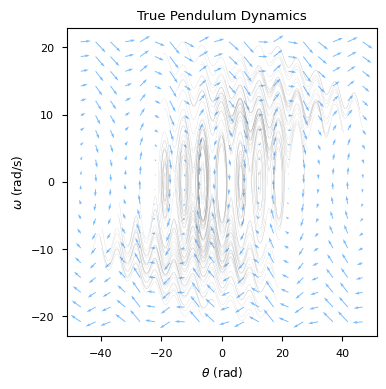

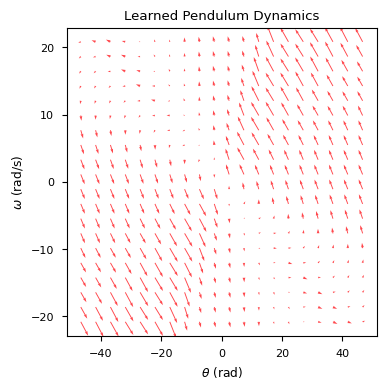

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0: 15.837159655335403
1: 15.706429539173135
2: 15.071578814546356
3: 14.64764315740926
4: 13.664239071207762
5: 13.450604964915405
6: 13.34256715136232
7: 12.482699351940296
8: 12.19532153855064
9: 12.020091709624122
10: 11.669020590743484
11: 11.201183356478085
12: 11.547011696637767
13: 10.738817510703612
14: 10.370760793607683
15: 10.816435971965348
16: 10.49307562298436
17: 9.97050021174696
18: 9.272564719709235
19: 9.6199849296604
20: 9.435494178362037
21: 9.039831545686434
22: 9.387139528188541
23: 8.891070480450953
24: 8.795528598224283
25: 8.637060135325928
26: 8.32311018687901
27: 8.140907962137916
28: 7.816192691570374
29: 8.00345573723346
30: 7.8046791293729285
31: 7.4977230126429095
32: 7.4516024183969805
33: 7.523666445478846
34: 7.140861654416219
35: 7.454968863247025
36: 7.

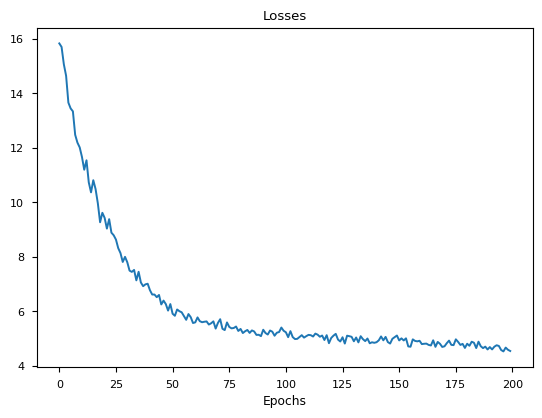

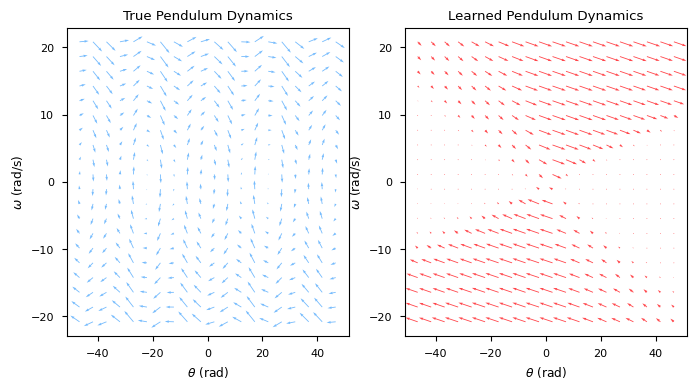

Batch Size 64:


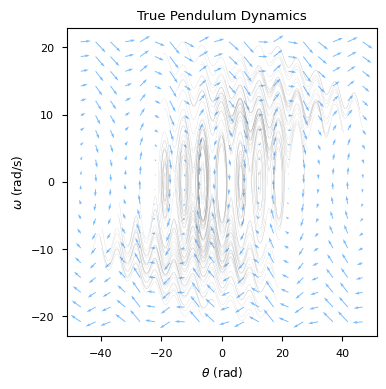

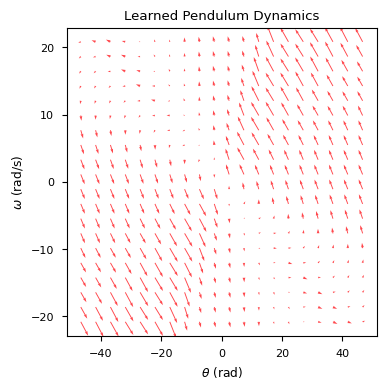

0: 15.87641040616677
1: 16.41484570352884
2: 15.816626290996062
3: 15.610577681833512
4: 14.236301606035509
5: 14.346578077403933
6: 14.83459710545447
7: 13.421113407084594
8: 13.307390732086969
9: 13.370867224129656
10: 13.297141398571917
11: 12.541528239323092
12: 13.845660101079655
13: 12.37543896013856
14: 11.834780991698665
15: 13.430251253356133
16: 13.213703550002856
17: 11.953360375728355
18: 10.283900797329387
19: 11.996483339939193
20: 11.810660550200906
21: 10.664203688601706
22: 12.217192766602956
23: 11.309677015455433
24: 11.120215940950107
25: 11.107682077519131
26: 10.38009756783217
27: 10.120908628691572
28: 9.72359354457552
29: 10.048587859290526
30: 9.88428437194034
31: 9.49735770179629
32: 9.60468634775461
33: 9.722551964368384
34: 9.043155062832147
35: 9.780395335170422
36: 9.230079744002778
37: 8.504645491598623
38: 8.809081869024272
39: 9.14579348300326
40: 8.827229900693133
41: 8.691779068978718
42: 8.523063340567276
43: 8.480402737708776
44: 8.712482683361381
4

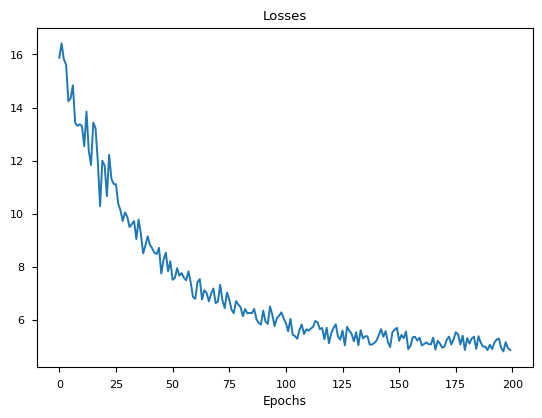

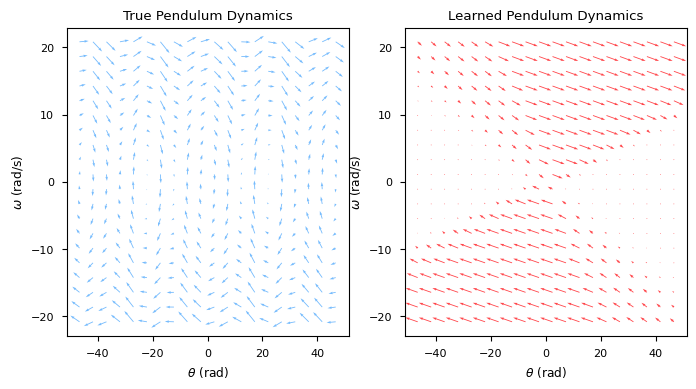

Batch Size 128:


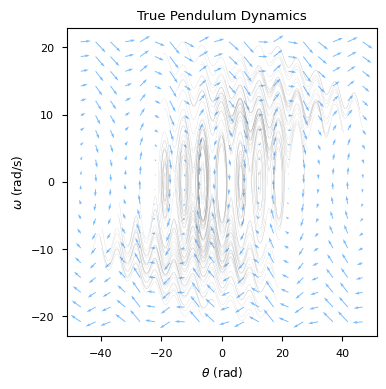

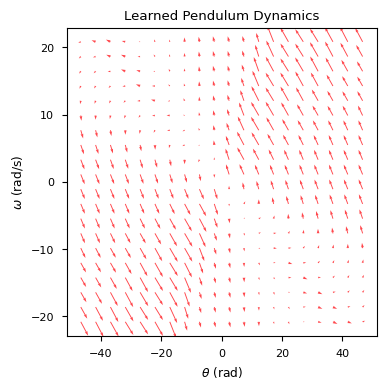

0: 15.93156844588304
1: 15.842750193619436
2: 15.760011755556693
3: 15.632194616345522
4: 15.595098796623011
5: 15.032590905001477
6: 15.283759555015374
7: 14.56024422144573
8: 14.91951596021084
9: 14.696300301494436
10: 14.240813040253535
11: 14.372588213031015
12: 14.15542839594062
13: 14.331070915596463
14: 14.094557539467374
15: 14.055732836187293
16: 13.771288490865757
17: 13.425254077055834
18: 13.395014714550712
19: 13.455192876612008
20: 13.403175581718338
21: 12.819494337180874
22: 13.1677576643884
23: 13.056537283288412
24: 12.903679689428206
25: 12.888911597685965
26: 12.293067442393898
27: 12.691772214517112
28: 12.489419357559854
29: 12.347119717145308
30: 12.025629952954464
31: 12.242727249713823
32: 11.736940794986403
33: 11.953668048075127
34: 11.738659906054542
35: 11.668742611748044
36: 11.46691085350381
37: 11.647336658546635
38: 11.303531345571088
39: 11.274003824170446
40: 11.34995823612524
41: 11.18529821603416
42: 11.110696903441863
43: 10.937563118800956
44: 10.

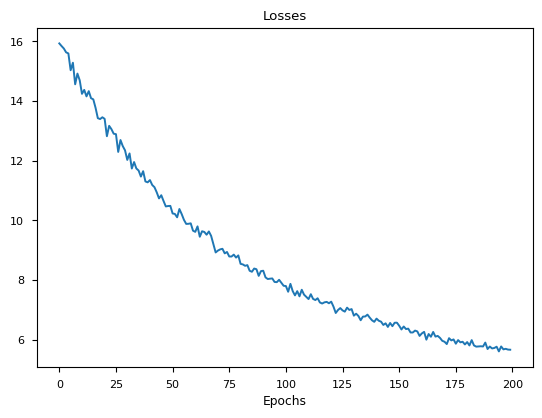

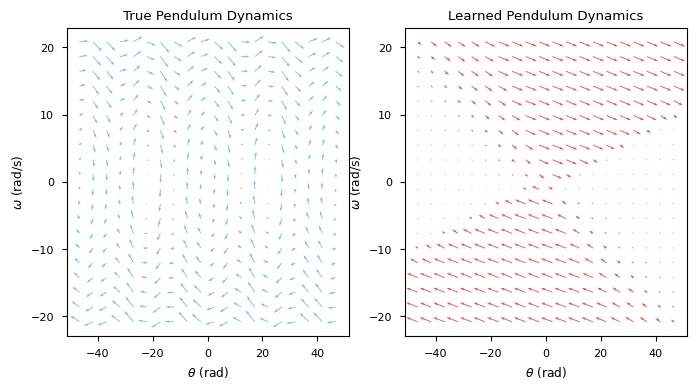

Batch Size 256:


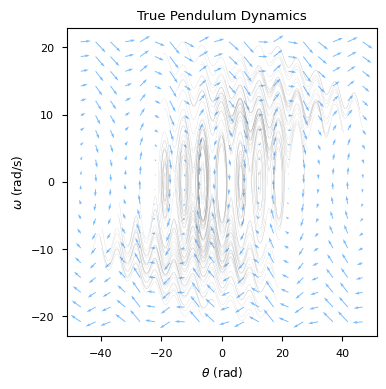

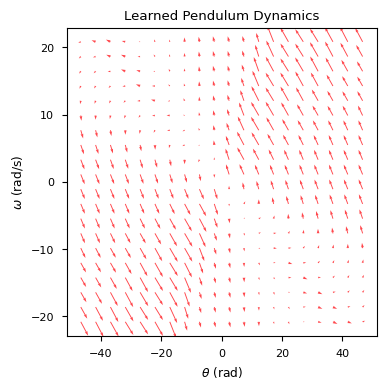

0: 16.128425684858886
1: 16.04586053117914
2: 15.963609400629743
3: 15.881705869562854
4: 15.80018252231841
5: 15.71907003062015
6: 15.638405947806268
7: 15.558237463537116
8: 15.478616753684898
9: 15.39959516978151
10: 15.321224134955365
11: 15.24356336887902
12: 15.166674132174014
13: 15.090581244531403
14: 15.015244856370673
15: 14.940585941820146
16: 14.866527539889999
17: 14.79301227082793
18: 14.72000197984414
19: 14.647473082858987
20: 14.575413153872118
21: 14.503822000463169
22: 14.43276675874308
23: 14.362816304626877
24: 14.29362764189916
25: 14.224967884173479
26: 14.15682515414576
27: 14.089199562598873
28: 14.02209322533755
29: 13.955508362268374
30: 13.889446535618506
31: 13.823908283955122
32: 13.758892970189113
33: 13.694398761947632
34: 13.630422697981794
35: 13.566960812103236
36: 13.504008293969713
37: 13.441559668742602
38: 13.379608979375371
39: 13.318149958191398
40: 13.257176178932436
41: 13.19668118612512
42: 13.136658604243157
43: 13.077102232953834
44: 13.018

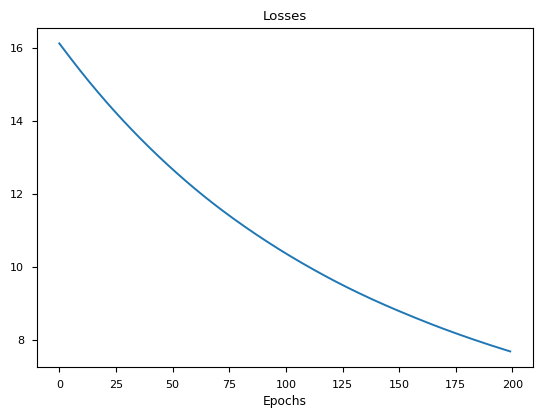

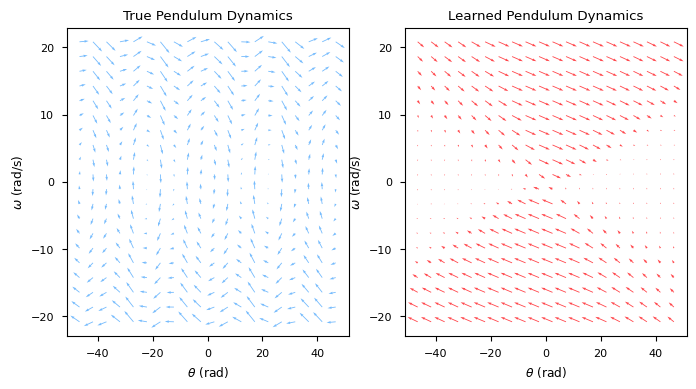

Batch Size 512:


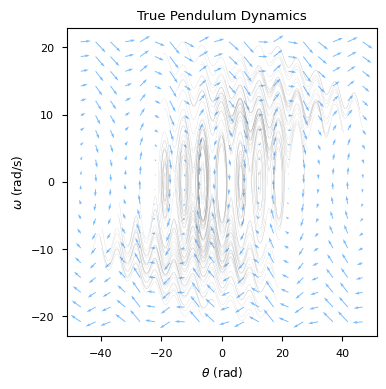

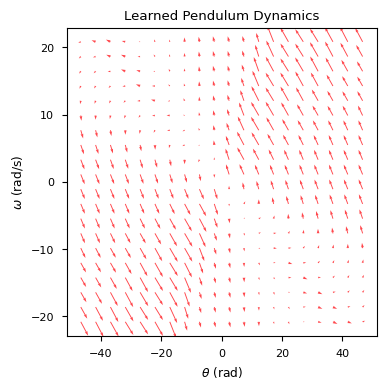

0: 16.128425684858886
1: 16.04586053117914
2: 15.963609400629743
3: 15.881705869562854
4: 15.80018252231841
5: 15.71907003062015
6: 15.638405947806268
7: 15.558237463537116
8: 15.478616753684898
9: 15.39959516978151
10: 15.321224134955365
11: 15.24356336887902
12: 15.166674132174014
13: 15.090581244531403
14: 15.015244856370673
15: 14.940585941820146
16: 14.866527539889999
17: 14.79301227082793
18: 14.72000197984414
19: 14.647473082858987
20: 14.575413153872118
21: 14.503822000463169
22: 14.43276675874308
23: 14.362816304626877
24: 14.29362764189916
25: 14.224967884173479
26: 14.15682515414576
27: 14.089199562598873
28: 14.02209322533755
29: 13.955508362268374
30: 13.889446535618506
31: 13.823908283955122
32: 13.758892970189113
33: 13.694398761947632
34: 13.630422697981794
35: 13.566960812103236
36: 13.504008293969713
37: 13.441559668742602
38: 13.379608979375371
39: 13.318149958191398
40: 13.257176178932436
41: 13.19668118612512
42: 13.136658604243157
43: 13.077102232953834
44: 13.018

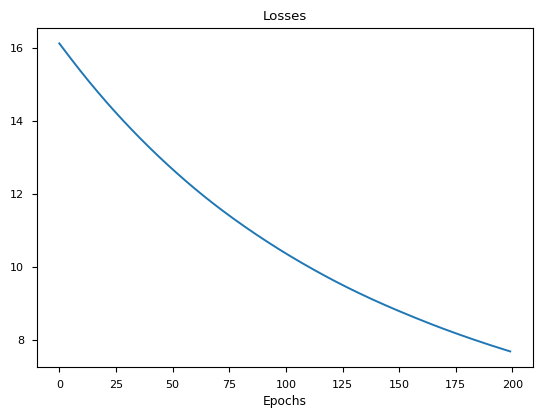

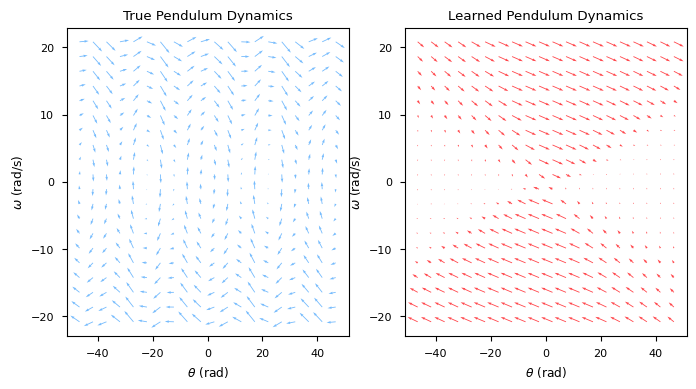

Batch Size 1001:


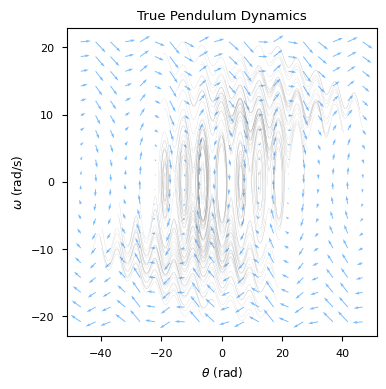

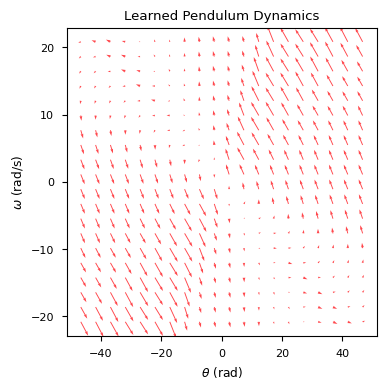

0: 16.128425684858886
1: 16.04586053117914
2: 15.963609400629743
3: 15.881705869562854
4: 15.80018252231841
5: 15.71907003062015
6: 15.638405947806268
7: 15.558237463537116
8: 15.478616753684898
9: 15.39959516978151
10: 15.321224134955365
11: 15.24356336887902
12: 15.166674132174014
13: 15.090581244531403
14: 15.015244856370673
15: 14.940585941820146
16: 14.866527539889999
17: 14.79301227082793
18: 14.72000197984414
19: 14.647473082858987
20: 14.575413153872118
21: 14.503822000463169
22: 14.43276675874308
23: 14.362816304626877
24: 14.29362764189916
25: 14.224967884173479
26: 14.15682515414576
27: 14.089199562598873
28: 14.02209322533755
29: 13.955508362268374
30: 13.889446535618506
31: 13.823908283955122
32: 13.758892970189113
33: 13.694398761947632
34: 13.630422697981794
35: 13.566960812103236
36: 13.504008293969713
37: 13.441559668742602
38: 13.379608979375371
39: 13.318149958191398
40: 13.257176178932436
41: 13.19668118612512
42: 13.136658604243157
43: 13.077102232953834
44: 13.018

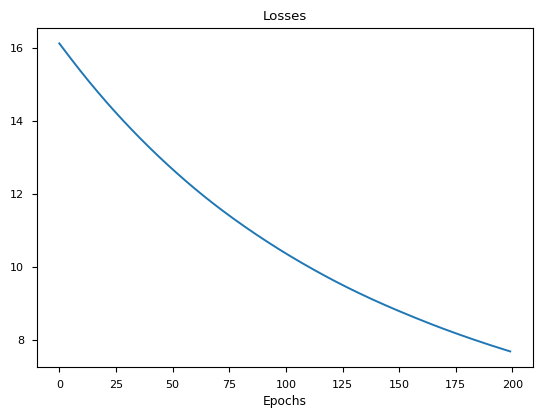

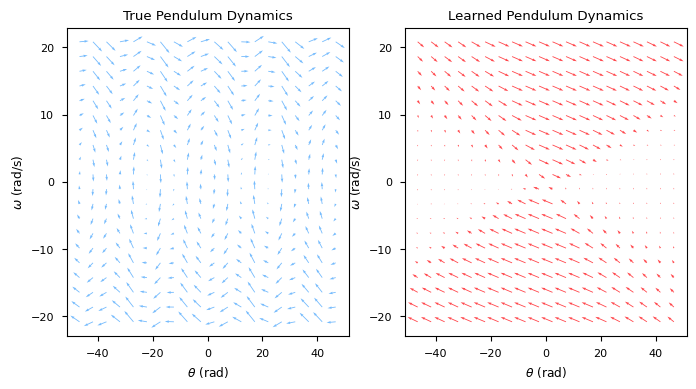

In [19]:
batch_results = {}
for batch_size in batch_sizes:
    tf.random.set_seed(0)
    dxdt = feed_forward_model(initializer=xavier)
    print(f"Batch Size {batch_size}:")
    duration_s, loss = experiment(dxdt, terminal_only_loss, None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                  traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                  solver_args=solver_args, batch_size=batch_size, adjoint=adjoint, plot_rate=0)
    batch_results[batch_size] = (duration_s, loss)

In [20]:
table = "| batch size | duration (s) | evaluation loss (mse) |\n| --- | --- | --- |\n"
table += "\n".join([f"| {batch_size} | {duration_s:.2f} | {loss:.2f} |" for batch_size, (duration_s, loss) in batch_results.items()])
display(Markdown(table))

| batch size | duration (s) | evaluation loss (mse) |
| --- | --- | --- |
| 32 | 4876.69 | 4.95 |
| 64 | 2941.43 | 5.41 |
| 128 | 1377.25 | 6.01 |
| 256 | 740.61 | 8.11 |
| 512 | 727.64 | 8.11 |
| 1001 | 736.81 | 8.11 |

In [21]:
best_batch_size = min(batch_results.items(), key=lambda r: r[1][1])[0]
print("Best batch size:", best_batch_size)

Best batch size: 32


## Activation Experiments

In [40]:
activations = ("tanh", "relu")

Activation tanh:


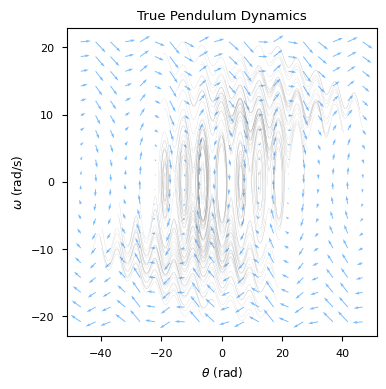

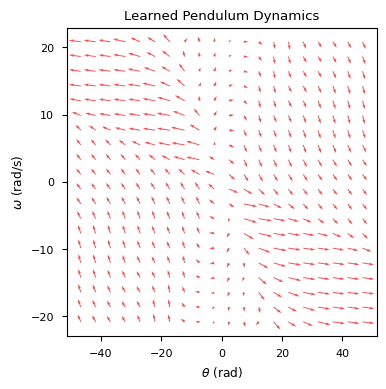

0: 15.17009807116224
1: 15.0284348915151
2: 14.614582740802815
3: 14.294119445806102
4: 13.291545177491482
5: 13.324404708606684
6: 13.15000449865047
7: 12.469802564411363
8: 12.172132958114997
9: 12.137723918814698
10: 11.875751437206594
11: 11.42979009295826
12: 11.910353639146207
13: 11.13169898741185
14: 10.729471752563601
15: 11.249427133399163
16: 10.915401205323747
17: 10.38711842017423
18: 9.477307806020415
19: 9.865633193768252
20: 9.689560200472451
21: 9.153615835468061
22: 9.544528590595107
23: 9.045998440156746
24: 8.89906655375832
25: 8.68895256757038
26: 8.371024668924305
27: 8.177298992861056
28: 7.838959799785777
29: 8.019857740521045
30: 7.788631043021344
31: 7.471735329672426
32: 7.374316687234911
33: 7.457427963107377
34: 7.102601266300712
35: 7.370366532879134
36: 6.976233756488058
37: 6.804840277324799
38: 6.8817749874484395
39: 6.915287563604385
40: 6.6758940682276995
41: 6.506604778707649
42: 6.517010162903
43: 6.3873920167745775
44: 6.467706962403639
45: 6.19902

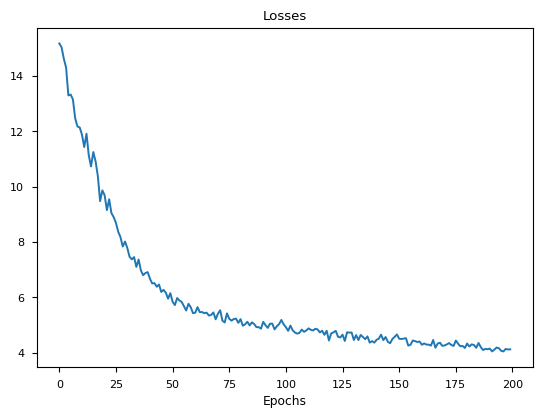

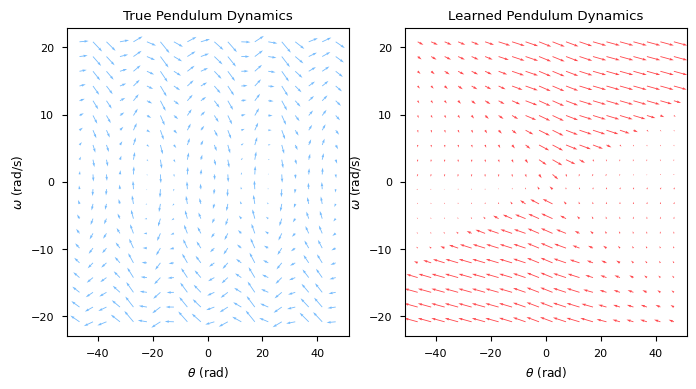

Activation relu:


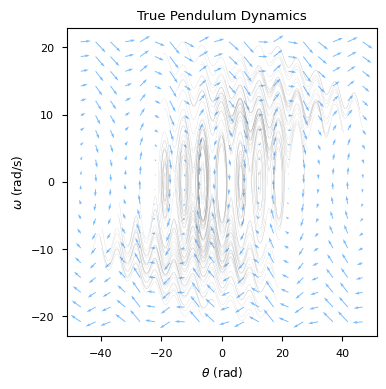

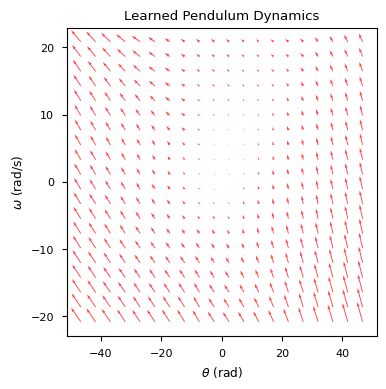

0: 16.30093597342333
1: 15.32102479083187
2: 14.983573050126683
3: 14.096364974943452
4: 12.727265196733223
5: 12.54274953195384
6: 12.177221427269576
7: 11.525859603802875
8: 11.013203401943965
9: 10.509556184943452
10: 10.425279678521898
11: 9.876043801143513
12: 10.073520536823255
13: 9.473153737014972
14: 9.125145847911583
15: 9.068149586170572
16: 9.33015289013735
17: 8.84267674579551
18: 7.947952929131559
19: 7.877804681327852
20: 8.166633737418
21: 7.447966690398822
22: 7.699488067021322
23: 7.1907894326023305
24: 6.9856479417723945
25: 6.890186454042911
26: 7.070428881947886
27: 6.487117589875707
28: 6.5767994139712584
29: 6.073369091284614
30: 6.201390074589125
31: 5.732654404785607
32: 5.639748597446844
33: 5.418806140968529
34: 5.379160843097074
35: 5.558252874468279
36: 5.263855938053115
37: 5.196068987687686
38: 5.179077119953141
39: 5.289628926141922
40: 4.781239876837437
41: 4.753379570417769
42: 4.6782908190179535
43: 4.607991645705494
44: 4.58144342933521
45: 4.5836532

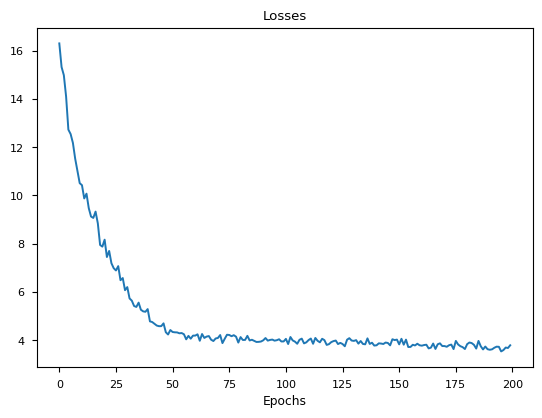

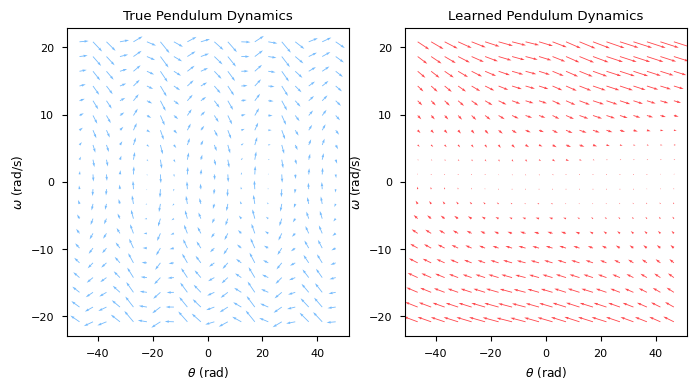

In [41]:
activation_results = {}
for activation in activations:
    tf.random.set_seed(0)
    dxdt = feed_forward_model(activation=activation)
    print(f"Activation {activation}:")
    duration_s, loss = experiment(dxdt, terminal_only_loss, None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                  traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                  solver_args=solver_args, batch_size=best_batch_size, adjoint=adjoint, plot_rate=0)
    activation_results[activation] = (duration_s, loss)

In [42]:
table = "| Activation | duration (s) | evaluation loss (mse) |\n| --- | --- | --- |\n"
table += "\n".join([f"| {activation} | {duration_s:.2f} | {loss:.2f} |" for activation, (duration_s, loss) in activation_results.items()])
display(Markdown(table))

| Activation | duration (s) | evaluation loss (mse) |
| --- | --- | --- |
| tanh | 4975.87 | 4.54 |
| relu | 4543.19 | 4.19 |

In [43]:
best_activation = min(activation_results.items(), key=lambda r: r[1][1])[0]
print("Best activation:", best_activation)

Best activation: relu


## Initializer Experiments

In [22]:
initializers = {"xavier": xavier,
                "xavier_norm": xavier_norm,
                "init_random": init_random,
                "init_random_norm": init_random_norm,
                "init_constant_0_5": init_constant_0_5,
                "init_constant_1": init_constant_1}

Initializer xavier:


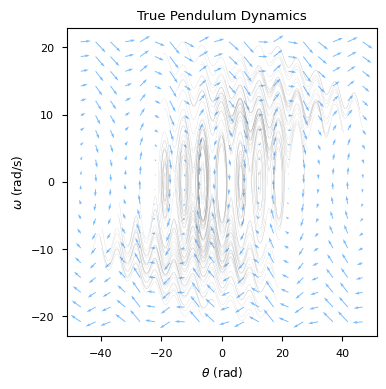

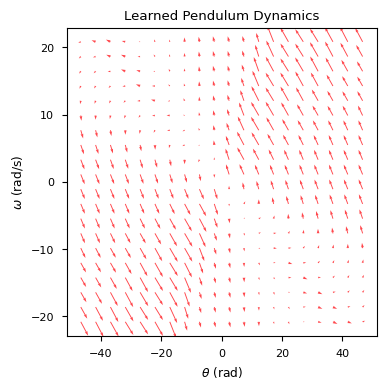

0: 15.837159655335403
1: 15.706429539173135
2: 15.071578814546356
3: 14.64764315740926
4: 13.664239071207762
5: 13.450604964915405
6: 13.34256715136232
7: 12.482699351940296
8: 12.19532153855064
9: 12.020091709624122
10: 11.669020590743484
11: 11.201183356478085
12: 11.547011696637767
13: 10.738817510703612
14: 10.370760793607683
15: 10.816435971965348
16: 10.49307562298436
17: 9.97050021174696
18: 9.272564719709235
19: 9.6199849296604
20: 9.435494178362037
21: 9.039831545686434
22: 9.387139528188541
23: 8.891070480450953
24: 8.795528598224283
25: 8.637060135325928
26: 8.32311018687901
27: 8.140907962137916
28: 7.816192691570374
29: 8.00345573723346
30: 7.8046791293729285
31: 7.4977230126429095
32: 7.4516024183969805
33: 7.523666445478846
34: 7.140861654416219
35: 7.454968863247025
36: 7.063111133322051
37: 6.92708329493271
38: 6.993720967973318
39: 7.016342805585416
40: 6.779411743902516
41: 6.620563220562706
42: 6.620517134989732
43: 6.523895443329134
44: 6.60472607056469
45: 6.25699

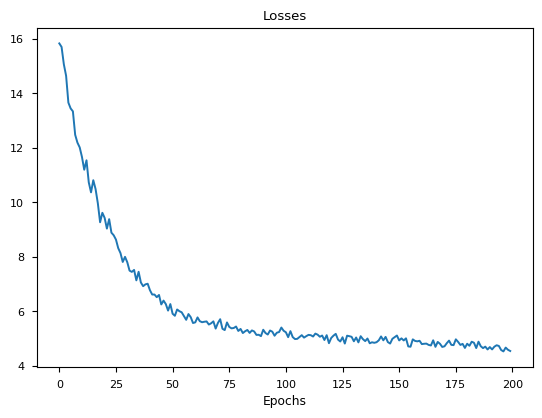

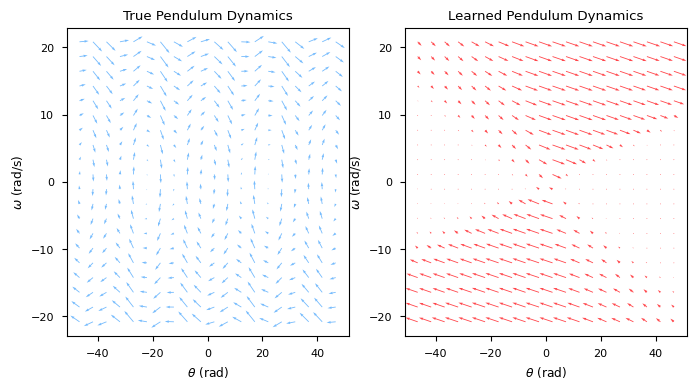

Initializer xavier_norm:


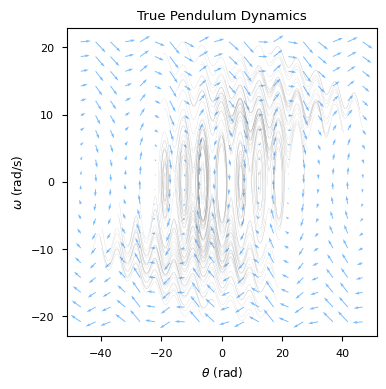

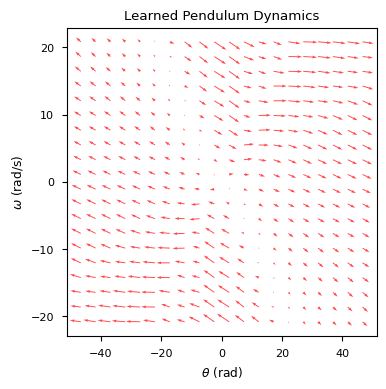

0: 14.059842492378985
1: 13.933341347401202
2: 13.504543560399943
3: 13.178597988293957
4: 12.273106129161906
5: 12.27603048677228
6: 12.094238868369816
7: 11.40249820583612
8: 11.198560512074904
9: 11.140403542721147
10: 10.800964086936736
11: 10.448061062213425
12: 10.832202517242976
13: 10.130066942861731
14: 9.760710544574101
15: 10.246527531800083
16: 9.976948861177897
17: 9.56682163629286
18: 8.835960921323757
19: 9.18510030534279
20: 9.080718328255013
21: 8.693856620659187
22: 9.06338700508596
23: 8.628640266843977
24: 8.547854990176157
25: 8.379056917118302
26: 8.124406458077173
27: 7.962482981006923
28: 7.6905610929601185
29: 7.868712125038132
30: 7.676801182957001
31: 7.393387896699835
32: 7.312340366260998
33: 7.4186576211865844
34: 7.107143725219665
35: 7.374685548849486
36: 6.9765661739686635
37: 6.856183475035746
38: 6.934836865934865
39: 6.942147240891236
40: 6.735892623065305
41: 6.564713252280618
42: 6.578344301988222
43: 6.472494132559744
44: 6.538823123624937
45: 6.2

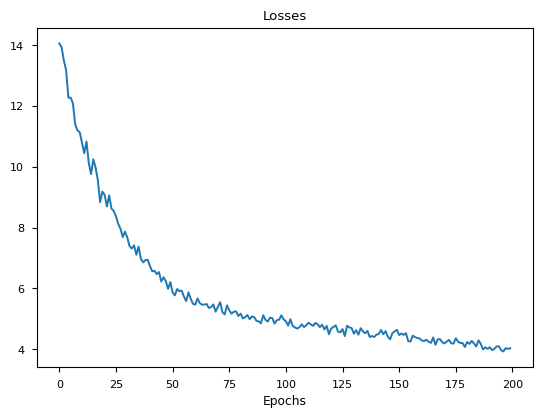

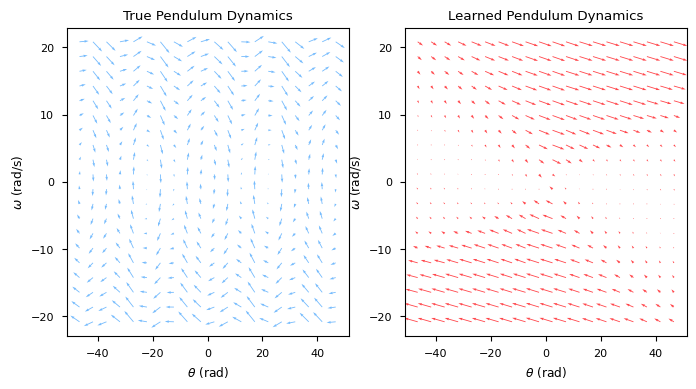

Initializer init_random:


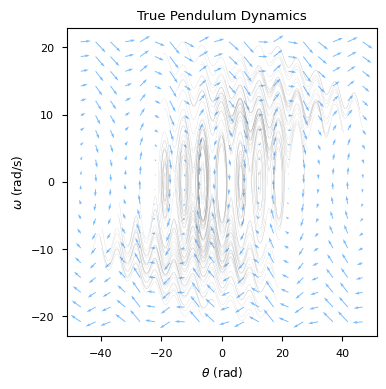

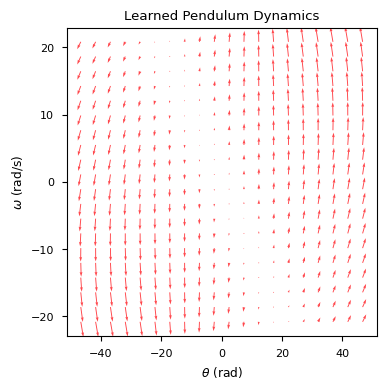

0: 15.164228359052979
1: 15.49936296415463
2: 15.331589203833657
3: 15.263850073392108
4: 14.457698226778641
5: 14.523994402209016
6: 14.477523200893618
7: 13.55711835074283
8: 13.213556378066022
9: 13.076506991801773
10: 12.809295736580749
11: 12.321430734540428
12: 12.774700359108968
13: 11.94126358495889
14: 11.54169853875256
15: 12.224095189706675
16: 12.069774846911745
17: 11.375090092630332
18: 10.526220102752493
19: 11.236704497828807
20: 11.114966530820814
21: 10.460863062328533
22: 11.203472028455236
23: 10.753132146864205
24: 10.583093336988563
25: 10.49708742356878
26: 10.065603528825836
27: 9.975356982890426
28: 9.808337798858371
29: 9.884447347743855
30: 9.667341863026596
31: 9.49290053592652
32: 9.420529910672522
33: 9.470320531537505
34: 9.175965528415386
35: 9.366594195686487
36: 9.092289212667845
37: 8.78291981660104
38: 8.830754720988777
39: 8.912284738486624
40: 8.694077881131154
41: 8.646249466569586
42: 8.49419178339269
43: 8.442222305912393
44: 8.481962828154137
4

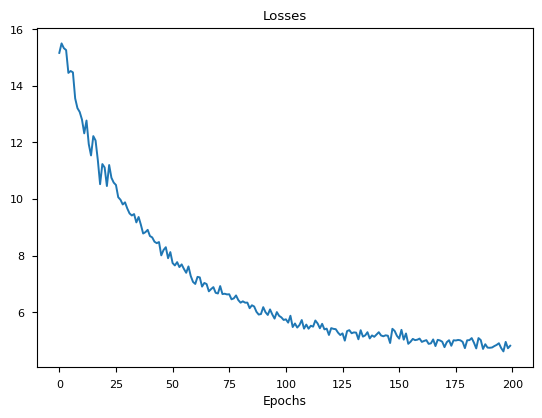

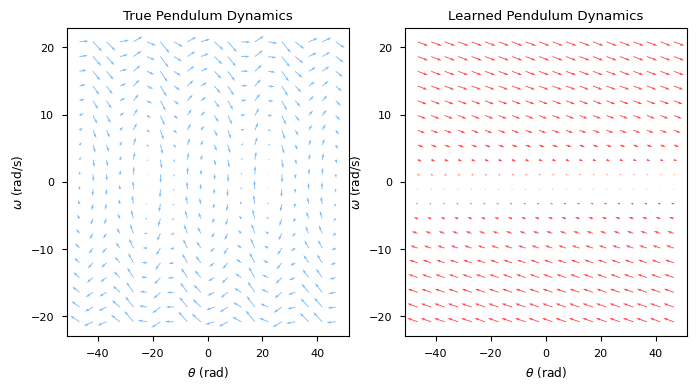

Initializer init_random_norm:


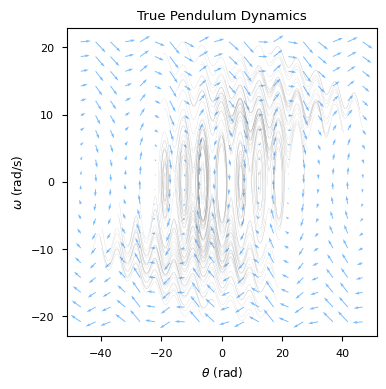

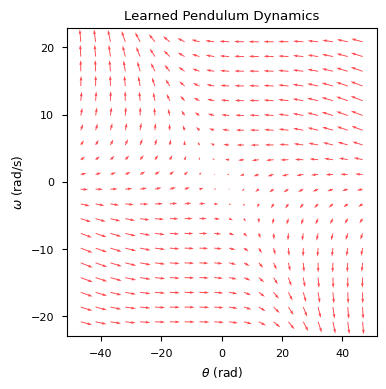

0: 15.180224135651473
1: 15.470868507094762
2: 15.281543923178123
3: 15.207754664009643
4: 14.409669459851717
5: 14.514226975903133
6: 14.502744291548636
7: 13.61292722936281
8: 13.285218049266364
9: 13.141988999578421
10: 12.859232920828436
11: 12.342909283335453
12: 12.763988088971425
13: 11.903860099642568
14: 11.486513062078725
15: 12.142460106864219
16: 11.974394188909443
17: 11.273206732624098
18: 10.433284333768247
19: 11.113746215918757
20: 10.986289554055162
21: 10.34279683535283
22: 11.062262637507036
23: 10.60923692274248
24: 10.441265201487186
25: 10.347524019722718
26: 9.921048239752837
27: 9.827879358291009
28: 9.65894203027911
29: 9.733426416569596
30: 9.506967684604277
31: 9.329922380889835
32: 9.25498756775954
33: 9.307647086827307
34: 9.015911921108714
35: 9.202270603979011
36: 8.918163363379147
37: 8.634070800335945
38: 8.67820902064239
39: 8.749554764209815
40: 8.528447092434762
41: 8.476720534873529
42: 8.337182484494438
43: 8.280246822944749
44: 8.322457841347717


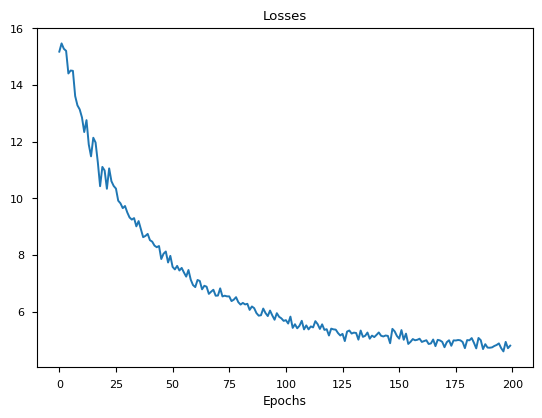

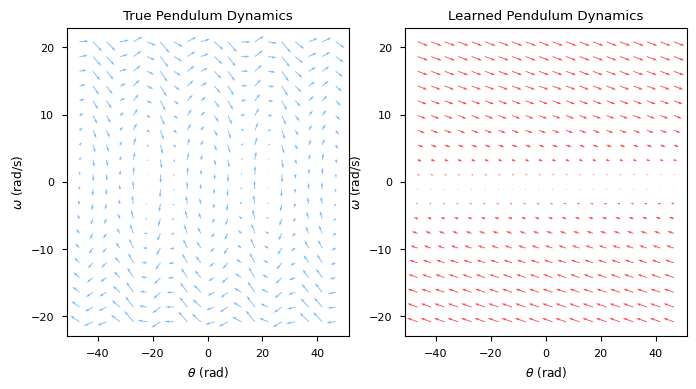

Initializer init_constant_0_5:


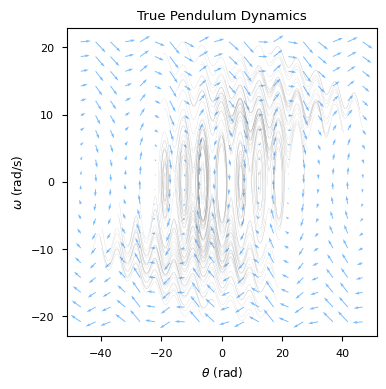

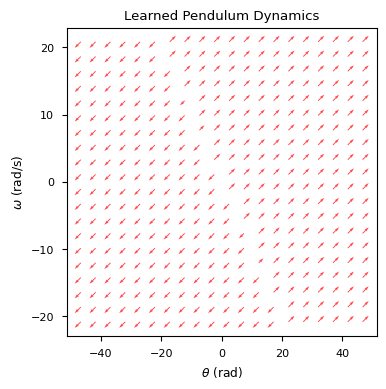

0: 24.35474354942418
1: 24.407898570050836
2: 24.164699200750306
3: 24.125811693930014
4: 23.519032299795075
5: 23.20505525131974
6: 23.308203015647937
7: 23.052896522581015
8: 22.958419238157152
9: 22.343548144850796
10: 22.476235859439537
11: 22.006903942721575
12: 22.209814848738745
13: 21.714463427932753
14: 21.36742763960716
15: 21.768402367120522
16: 21.265134332612178
17: 20.846265290298845
18: 20.38768517062109
19: 20.95548601002667
20: 20.539994594994027
21: 19.97202213520003
22: 20.407005266671515
23: 19.989186279280773
24: 19.661103419650793
25: 19.522828208235833
26: 19.33859752048466
27: 18.932739610516812
28: 18.60785311184585
29: 18.774803344466278
30: 18.77134999974367
31: 18.23591438470152
32: 18.465140889023264
33: 18.007973705560744
34: 17.86895001374727
35: 18.130837721614462
36: 18.014126256499672
37: 17.47369919701209
38: 17.234323588703152
39: 17.37934458481286
40: 17.23105798651594
41: 16.80163140633648
42: 16.232743269681063
43: 16.239611060429556
44: 15.570715

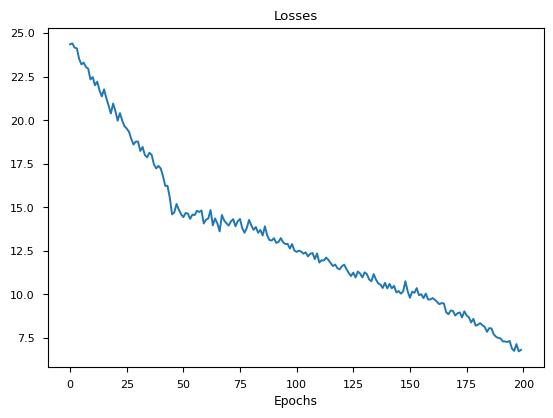

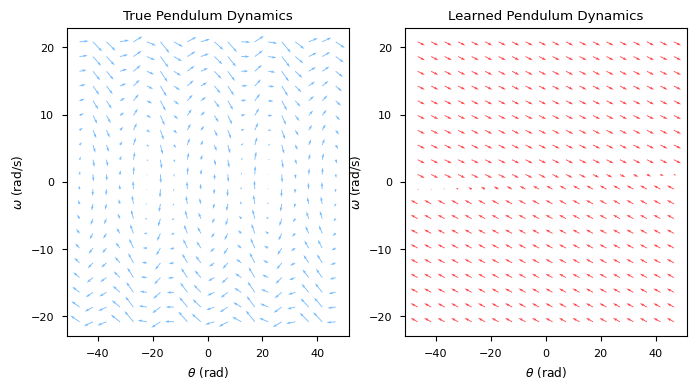

Initializer init_constant_1:


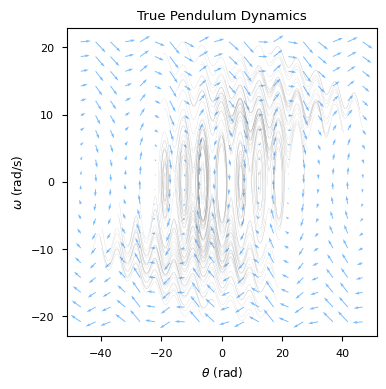

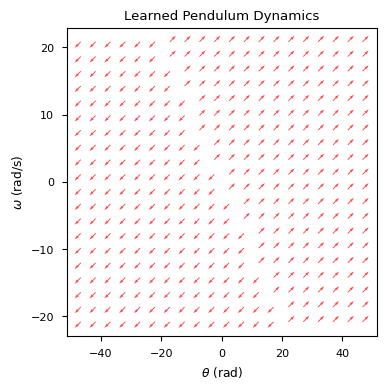

0: 43.69803560642579
1: 43.65636588160503
2: 43.313877195094165
3: 43.20328613446866
4: 42.64733073554151
5: 42.17631324408087
6: 42.111320616479325
7: 42.02587466922015
8: 41.872081442286074
9: 41.08312640145591
10: 41.14956128531566
11: 40.59189266591749
12: 40.44343476209188
13: 40.15227275402026
14: 39.80613766451758
15: 39.698007167341
16: 38.988781016147634
17: 38.7991656991738
18: 38.71142978194525
19: 38.699974333600174
20: 38.24388011320891
21: 37.853521523371704
22: 37.6480636793542
23: 37.28513836413048
24: 36.97527280183706
25: 36.65020954145671
26: 36.656389919816995
27: 36.06997687947087
28: 35.643383268272245
29: 35.71891211880649
30: 35.67567347776737
31: 34.90654677889504
32: 35.070303658950024
33: 34.329002867375486
34: 34.244055160916375
35: 34.23491448532796
36: 34.03586105754147
37: 33.612143086748
38: 33.18871995855282
39: 33.06575135456109
40: 32.82008821063177
41: 32.14953070282025
42: 31.881108888301775
43: 32.28316825404186
44: 31.821802869930362
45: 31.512855

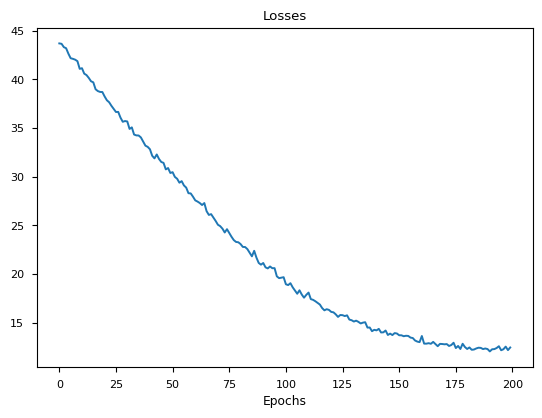

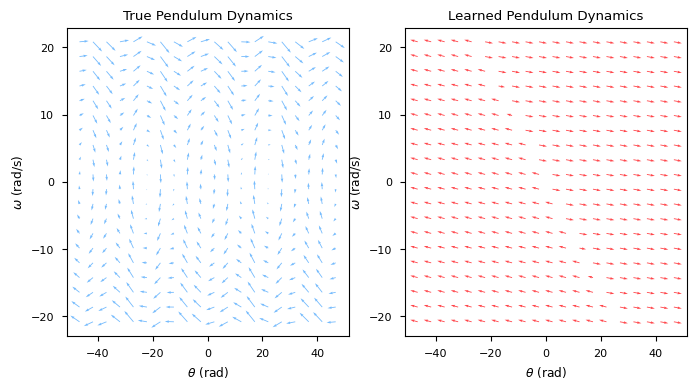

In [23]:
init_results = {}
for init_name, initializer in initializers.items():
    tf.random.set_seed(0)
    dxdt = feed_forward_model(initializer=initializer)
    print(f"Initializer {init_name}:")
    duration_s, loss = experiment(dxdt, terminal_only_loss, None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                  traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                  solver_args=solver_args, batch_size=best_batch_size, adjoint=adjoint, plot_rate=0)
    init_results[init_name] = (duration_s, loss)

In [24]:
table = "| Initializer | duration (s) | evaluation loss (mse) |\n| --- | --- | --- |\n"
table += "\n".join([f"| {init_name} | {duration_s:.2f} | {loss:.2f} |" for init_name, (duration_s, loss) in init_results.items()])
display(Markdown(table))

| Initializer | duration (s) | evaluation loss (mse) |
| --- | --- | --- |
| xavier | 4498.91 | 4.95 |
| xavier_norm | 4346.73 | 4.47 |
| init_random | 4371.34 | 5.14 |
| init_random_norm | 4316.95 | 5.12 |
| init_constant_0_5 | 4359.86 | 6.77 |
| init_constant_1 | 4395.08 | 12.67 |

In [25]:
best_init_name = min(init_results.items(), key=lambda r: r[1][1])[0]
best_init = initializers[best_init_name]
print("Best initializer:", best_init_name)

Best initializer: xavier_norm


## Terminal Loss Experiments

In [26]:
terminal_losses = {"terminal_only": terminal_only_loss,
                   "all_states": all_states_loss}

Terminal loss terminal_only:


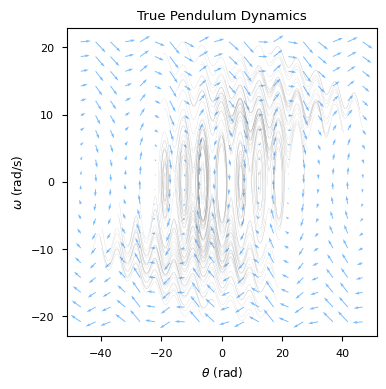

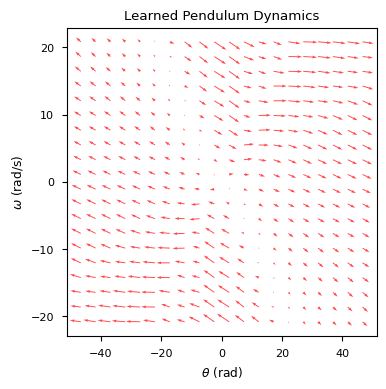

0: 14.059842492378985
1: 13.933341347401202
2: 13.504543560399943
3: 13.178597988293957
4: 12.273106129161906
5: 12.27603048677228
6: 12.094238868369816
7: 11.40249820583612
8: 11.198560512074904
9: 11.140403542721147
10: 10.800964086936736
11: 10.448061062213425
12: 10.832202517242976
13: 10.130066942861731
14: 9.760710544574101
15: 10.246527531800083
16: 9.976948861177897
17: 9.56682163629286
18: 8.835960921323757
19: 9.18510030534279
20: 9.080718328255013
21: 8.693856620659187
22: 9.06338700508596
23: 8.628640266843977
24: 8.547854990176157
25: 8.379056917118302
26: 8.124406458077173
27: 7.962482981006923
28: 7.6905610929601185
29: 7.868712125038132
30: 7.676801182957001
31: 7.393387896699835
32: 7.312340366260998
33: 7.4186576211865844
34: 7.107143725219665
35: 7.374685548849486
36: 6.9765661739686635
37: 6.856183475035746
38: 6.934836865934865
39: 6.942147240891236
40: 6.735892623065305
41: 6.564713252280618
42: 6.578344301988222
43: 6.472494132559744
44: 6.538823123624937
45: 6.2

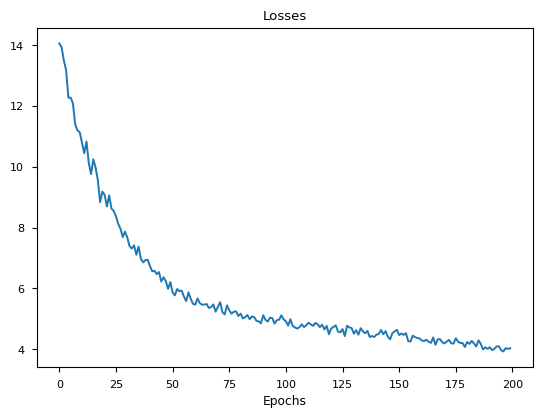

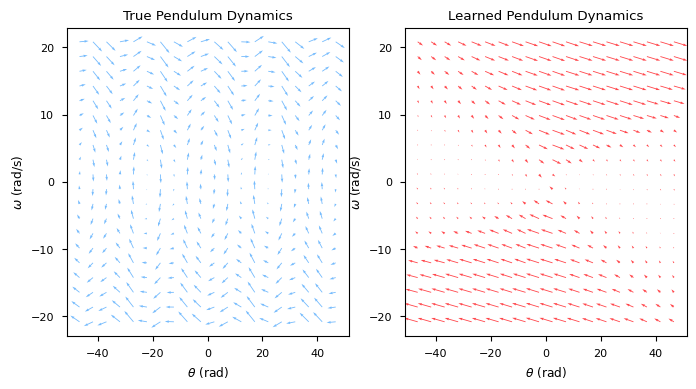

Terminal loss all_states:


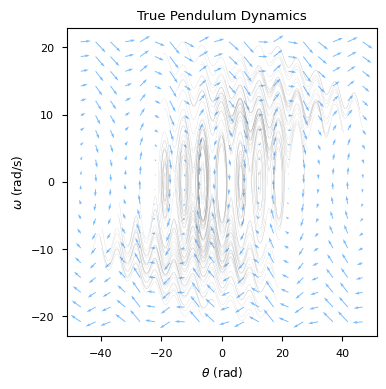

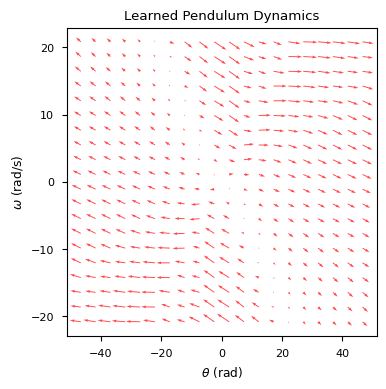

0: 457.91227294590624
1: 448.59436892391267
2: 438.13464965037826
3: 427.35528634994705
4: 414.62019060031463
5: 406.12683532667245
6: 398.3371167123468
7: 385.2678076343906
8: 379.0045970973287
9: 370.870576724492
10: 360.4491077863915
11: 352.0926179780477
12: 347.8523046179052
13: 337.8674367762157
14: 330.57483449877594
15: 329.33914232611335
16: 321.8821915662742
17: 315.7749663514341
18: 306.96809565788624
19: 305.71185464354727
20: 301.1733865752211
21: 296.5001704758532
22: 294.38892410829214
23: 289.68287243329075
24: 286.76192661386983
25: 282.47589843658625
26: 278.45771324438425
27: 274.504020974944
28: 269.6724650892731
29: 269.38459689977765
30: 262.7261142716514
31: 261.1228364449042
32: 257.98106203418064
33: 256.8567588028076
34: 253.12193381734073
35: 253.50491357095143
36: 248.18514484082752
37: 248.33682444927354
38: 246.0997968404034
39: 247.10191668261896
40: 242.36362925745416
41: 238.41030617563538
42: 239.05925556412856
43: 237.902115864925
44: 238.100813628158

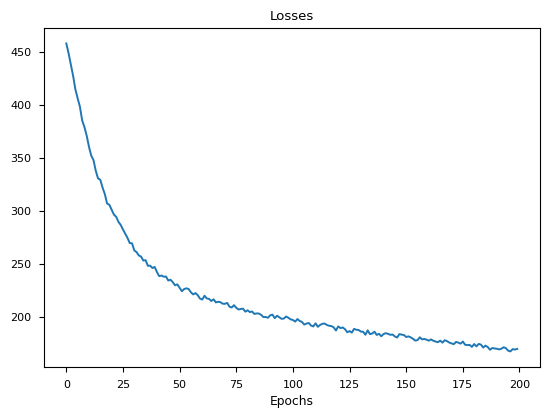

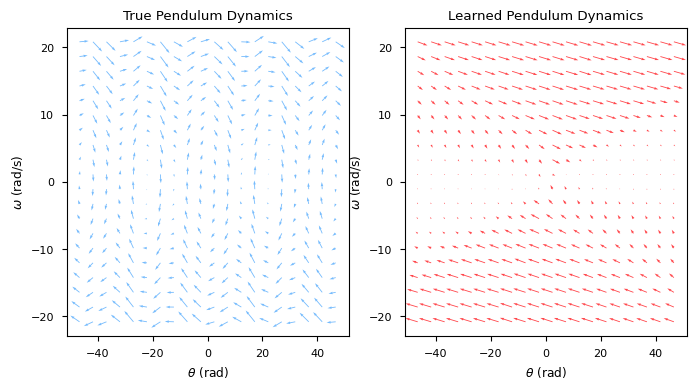

In [27]:
terminal_loss_results = {}
for loss_name, terminal_loss in terminal_losses.items():
    tf.random.set_seed(0)
    dxdt = feed_forward_model(initializer=best_init)
    print(f"Terminal loss {loss_name}:")
    duration_s, loss = experiment(dxdt, terminal_loss, None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                  traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                  solver_args=solver_args, batch_size=best_batch_size, adjoint=adjoint, plot_rate=0)
    terminal_loss_results[loss_name] = (duration_s, loss)

In [28]:
table = "| Initializer | duration (s) | evaluation loss (mse) |\n| --- | --- | --- |\n"
table += "\n".join([f"| {loss_name} | {duration_s:.2f} | {loss:.2f} |" for loss_name, (duration_s, loss) in terminal_loss_results.items()])
display(Markdown(table))

| Initializer | duration (s) | evaluation loss (mse) |
| --- | --- | --- |
| terminal_only | 4310.60 | 4.47 |
| all_states | 4260.57 | 4.46 |

In [29]:
best_loss_name = min(terminal_loss_results.items(), key=lambda r: r[1][1])[0]
best_loss = terminal_losses[best_loss_name]
print("Best terminal loss:", best_loss_name)

Best terminal loss: all_states


## Train with the Adjoint

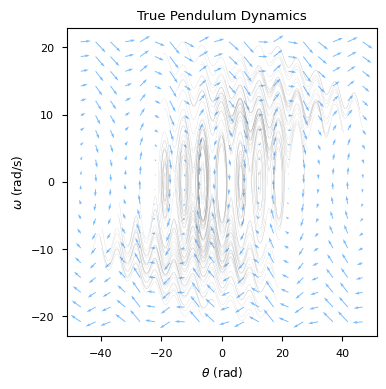

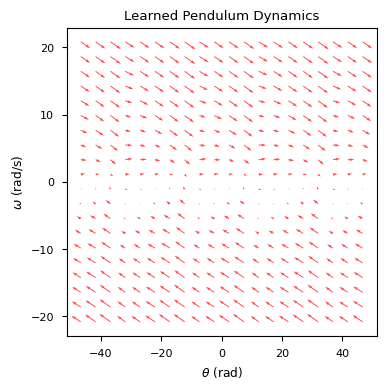

0: 444.07885579077083
1: 434.20411759801567
2: 423.19332107094607
3: 411.717204913767
4: 398.96423453773343
5: 390.11459627961995
6: 382.25442774934015
7: 369.4905474832959
8: 363.49982417816324
9: 355.8591342827779
10: 345.93285153608497
11: 338.5408762086923
12: 335.15454035920226
13: 325.93386353162134
14: 319.40068716053827
15: 318.5090951763
16: 312.0099070767402
17: 306.15055131005596
18: 298.2468261317363
19: 296.93519866702866
20: 292.60047779363697
21: 288.3694201569558
22: 286.4331507258665
23: 282.0377887923341
24: 279.5329382290571
25: 275.29086191094177
26: 271.54993107379784
27: 267.57359814420954
28: 263.5028545854833
29: 262.82903877356733
30: 256.80082911417884
31: 255.30457308689552
32: 251.5929802319143
33: 251.04509462280086
34: 248.09713393964677
35: 247.90061970029114
36: 242.74495639551773
37: 243.24895034184865
38: 241.2887620927491
39: 241.56847844307396
40: 236.60979426181186
41: 232.6379148317198
42: 233.32112629871133
43: 232.22756307321427
44: 231.941658175

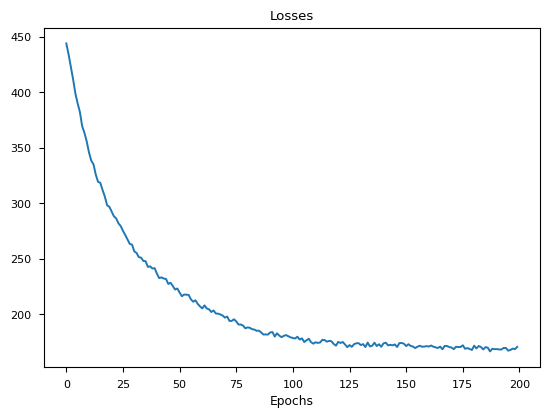

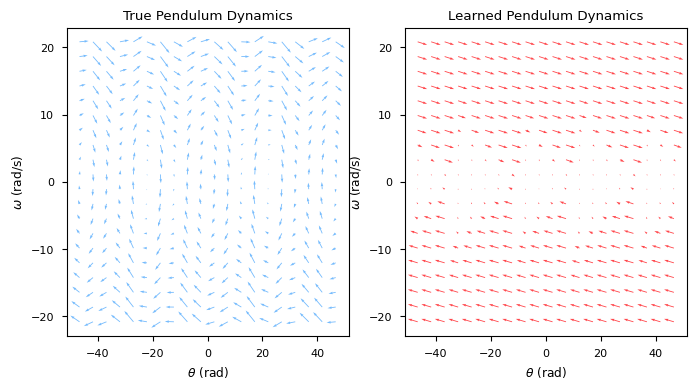

In [44]:
tf.random.set_seed(0)
dxdt = RotationalEncoding1d(best_init)
duration_s_adj, loss_adj = experiment(dxdt, best_loss, None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                      traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                      solver_args=solver_args, batch_size=best_batch_size, adjoint=True, plot_rate=0)

In [45]:
print(f"Adjoint - duration (s): {duration_s_adj:.2f}, loss (mse): {loss_adj:.2f}")

Adjoint - duration (s): 4679.17, loss (mse): 4.19


## 1D Rotational Encoding

In [30]:
class RotationalEncoding1d(tf.keras.Model):
    def __init__(self, init):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(initializer=init)
        
    def call(self, x):
        theta, omega = tf.unstack(x, axis=-1)
        theta_enc = tf.math.floormod(theta + 10*math.pi, 2*math.pi)
        x_enc = tf.stack([theta_enc, omega], axis=-1)
        return self._dxdt(x_enc)

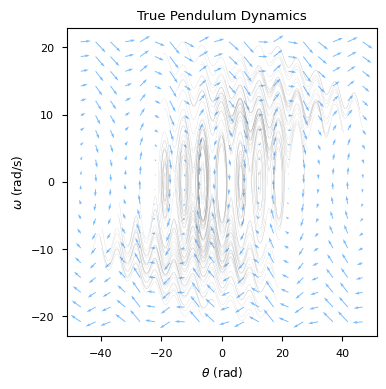

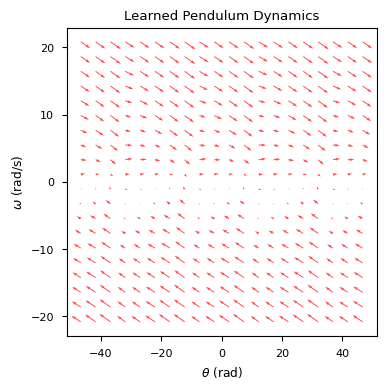

0: 444.030471821682
1: 434.06689748149745
2: 422.9840070652384
3: 411.4021262344928
4: 398.5086351261774
5: 389.5423679550987
6: 381.54352840260617
7: 368.6295748919594
8: 362.55909725280014
9: 354.8301273568448
10: 344.8528370390025
11: 337.3595910600191
12: 333.9252695551512
13: 324.61584547375134
14: 318.18665836355336
15: 317.2479211881563
16: 310.76726287567004
17: 304.97010626585865
18: 297.1069761528664
19: 295.870864996778
20: 291.5331148053432
21: 287.3191197920043
22: 285.3584894165445
23: 280.8644630293869
24: 278.3339400754882
25: 273.9676085157376
26: 270.1212740397162
27: 266.06288075142913
28: 261.9972472563182
29: 261.2289133178015
30: 254.89554275806478
31: 253.70368049554827
32: 249.83728725918422
33: 249.24845905888859
34: 246.0655705980421
35: 245.62466123215708
36: 240.5846924324118
37: 240.62193561637847
38: 238.7006026536035
39: 238.8469936231245
40: 233.83499401059976
41: 230.0769794125798
42: 230.21891254172093
43: 228.84438542626086
44: 228.42359059967725
45: 

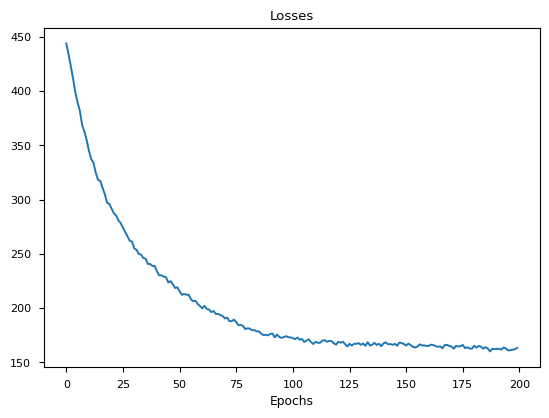

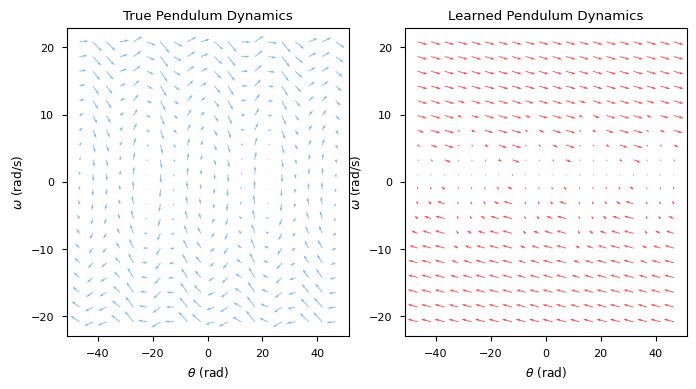

In [31]:
tf.random.set_seed(0)
dxdt = RotationalEncoding1d(best_init)
duration_s_1rot, loss_1rot = experiment(dxdt, best_loss, None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                        traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                        solver_args=solver_args, batch_size=best_batch_size, adjoint=adjoint, plot_rate=0)

In [32]:
print(f"1D rotation encoding - duration (s): {duration_s_1rot:.2f}, loss (mse): {loss_1rot:.2f}")

1D rotation encoding - duration (s): 4429.67, loss (mse): 4.11


## 2D Rotational Encoding

In [33]:
class RotationalEncoding2d(tf.keras.Model):
    def __init__(self, init):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(initializer=init)
        
    def call(self, x):
        theta, omega = tf.unstack(x, axis=-1)
        x_enc = tf.stack([tf.math.sin(theta), tf.math.cos(theta), omega], axis=-1)
        return self._dxdt(x_enc)

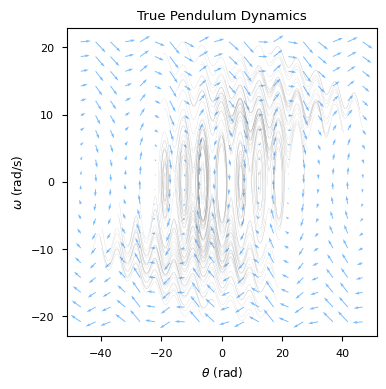

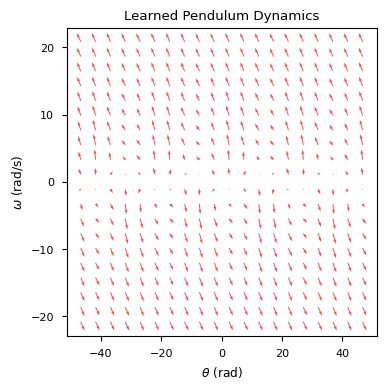

0: 507.4894679662448
1: 495.604876289924
2: 481.3908643690499
3: 466.30493428959284
4: 449.6186547807838
5: 436.4249796259022
6: 424.543567112466
7: 406.3346407444366
8: 395.36709979404714
9: 383.0944228231687
10: 369.5135764667451
11: 358.72234702917285
12: 353.34785072013455
13: 342.377312436625
14: 334.92807191234454
15: 333.9862812793621
16: 327.02218289713454
17: 320.9388014659564
18: 312.5762921623054
19: 312.38758216469193
20: 308.0800486491084
21: 303.628908581108
22: 302.44412019223995
23: 298.30824451321183
24: 295.8767812514919
25: 291.96222886950136
26: 288.15187388513027
27: 284.24886975463056
28: 280.43479629365265
29: 279.68476903962085
30: 273.21555853622874
31: 272.3278833337072
32: 268.6383408206026
33: 267.7576872404889
34: 264.4020446179653
35: 263.7208508205114
36: 258.9394159443842
37: 258.5800918389563
38: 256.175654802764
39: 256.2724449740404
40: 250.57062077121344
41: 247.21135419778676
42: 246.89640402856767
43: 245.38297884815697
44: 244.51401150392243
45: 2

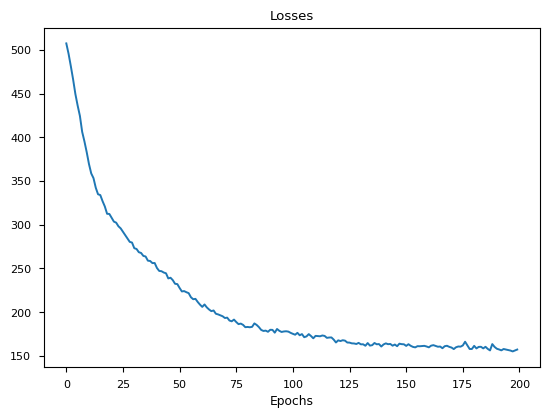

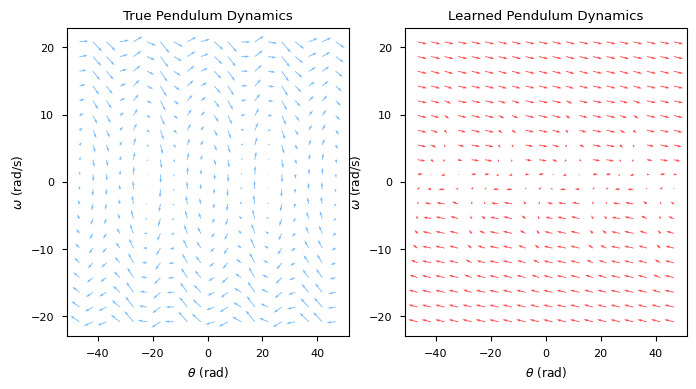

In [34]:
tf.random.set_seed(0)
dxdt = RotationalEncoding2d(best_init)
duration_s_2rot, loss_2rot = experiment(dxdt, best_loss, None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                        traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                        solver_args=solver_args, batch_size=best_batch_size, adjoint=adjoint, plot_rate=0)

In [35]:
print(f"2D rotation encoding - duration (s): {duration_s_2rot:.2f}, loss (mse): {loss_2rot:.2f}")

2D rotation encoding - duration (s): 4388.23, loss (mse): 4.20


## 2nd Order, 1D Rotational Encoding

In [48]:
class RotationalEncoding1dOrder2(tf.keras.Model):
    def __init__(self, init):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(initializer=init, out_dim=1)
        
    def call(self, x):
        theta, omega = tf.unstack(x, axis=-1)
        x_enc = tf.stack([tf.math.floormod(theta + 10*math.pi, 2*math.pi), omega], axis=-1)
        angular_acc = self._dxdt(x_enc)[..., 0]
        return tf.stack([omega, angular_acc], axis=-1)

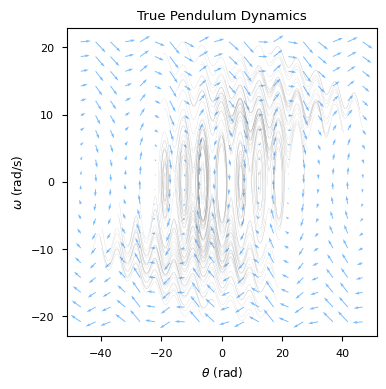

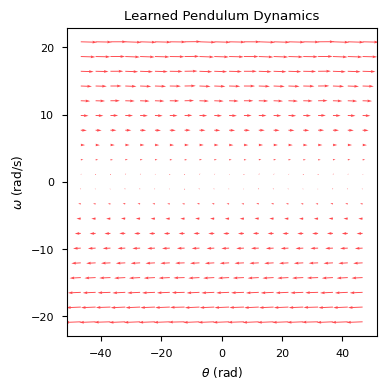

0: 279.70971655397915
1: 265.7217553015191
2: 249.18595937464352
3: 231.72504118931423
4: 220.43622494592708
5: 208.3918348140356
6: 197.02953376769196
7: 189.11615191148923
8: 183.93006793559852
9: 180.03337929031096
10: 172.0559443138356
11: 169.46687810601492
12: 168.02153904464726
13: 166.85033505591122
14: 167.5380974867628
15: 163.07263561215268
16: 162.46124863863403
17: 165.86997434822322
18: 166.4961654425296
19: 161.8725542762838
20: 165.24375990560642
21: 167.20393507134892
22: 164.53003167159753
23: 164.9029351443144
24: 166.29565697581037
25: 165.04634596318743
26: 164.82753927998513
27: 165.50363521759792
28: 162.7239516432283
29: 163.71467195936188
30: 162.76874777512427
31: 164.15050620190942
32: 162.85738681619378
33: 163.53465809104358
34: 162.32096430470543
35: 163.92238636650004
36: 161.5345799735525
37: 164.56774194777702
38: 163.78745134381666
39: 164.8192177710576
40: 164.16093673217406
41: 161.24487991495167
42: 163.07407722569147
43: 163.18562428518118
44: 162.

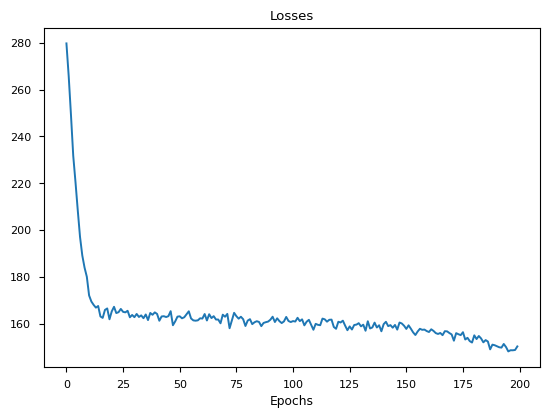

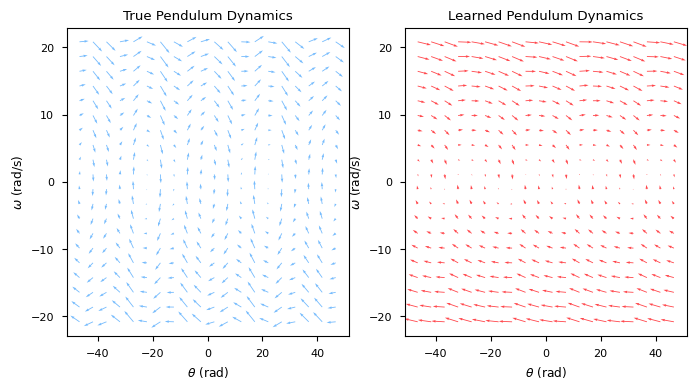

In [49]:
tf.random.set_seed(0)
dxdt = RotationalEncoding1dOrder2(best_init)
duration_s_1rot_order2, loss_1rot_order2 = experiment(dxdt, best_loss, None, terminal_only_loss, None, None,
                                                      epochs=epochs, lr=1e-3, traj_count=traj_count,
                                                      eval_traj_count=eval_traj_count, solver=solver,
                                                      solver_args=solver_args, batch_size=best_batch_size,
                                                      adjoint=adjoint, plot_rate=0)

In [50]:
print(f"2nd order 1D rotation encoding - duration (s): {duration_s_1rot_order2:.2f}, loss (mse): {loss_1rot_order2:.2f}")

2nd order 1D rotation encoding - duration (s): 4451.86, loss (mse): 3.68


## 2nd Order, 2D Rotational Encoding

In [21]:
class RotationalEncoding2dOrder2(tf.keras.Model):
    def __init__(self, activation, init):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(activation=activation, initializer=init, out_dim=1)
        
    def call(self, x):
        theta, omega = tf.unstack(x, axis=-1)
        x_enc = tf.stack([tf.math.sin(theta), tf.math.cos(theta), omega], axis=-1)
        angular_acc = self._dxdt(x_enc)[..., 0]
        return tf.stack([omega, angular_acc], axis=-1)

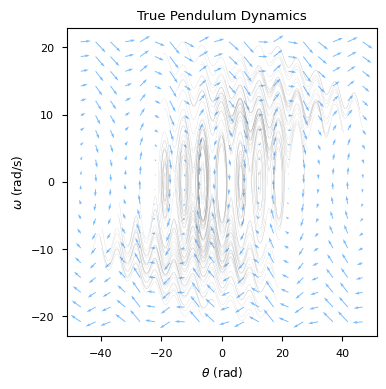

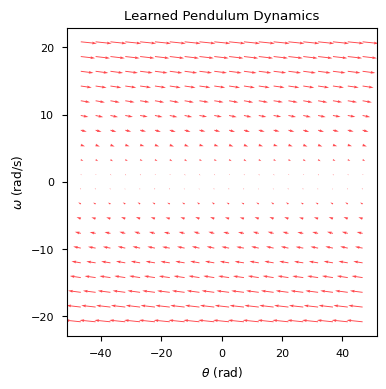

0: 194.97219979412847
1: 186.03197147749648
2: 178.28530154681062
3: 171.60591437339033
4: 169.17425796775166
5: 167.33580843445165
6: 164.3906065867512
7: 164.94138934797837
8: 166.11492520590235
9: 167.06925530575475
10: 162.8781008843893
11: 162.8449010828326
12: 163.32095672557125
13: 163.2616854783062
14: 164.69613393632457
15: 160.52562663008672
16: 160.63805138306225
17: 164.13224517127648
18: 164.86849868963182
19: 160.17461789946054
20: 163.67334896284436
21: 165.6190582328284
22: 163.01061464295117
23: 163.2562153517928
24: 164.61120778112044
25: 163.36737032078963
26: 163.17647862190657
27: 163.7137899424701
28: 160.7498226460929
29: 161.76045168796892
30: 160.95173995152487
31: 161.9576937732548
32: 160.60446438844045
33: 161.01084932275555
34: 159.6262316926937
35: 161.31126074294497
36: 158.63665566574196
37: 161.6510379406938
38: 160.58532940787012
39: 161.56386343119138
40: 160.59513179937858
41: 157.27890420414616
42: 158.86084414529768
43: 158.7827145608645
44: 158.16

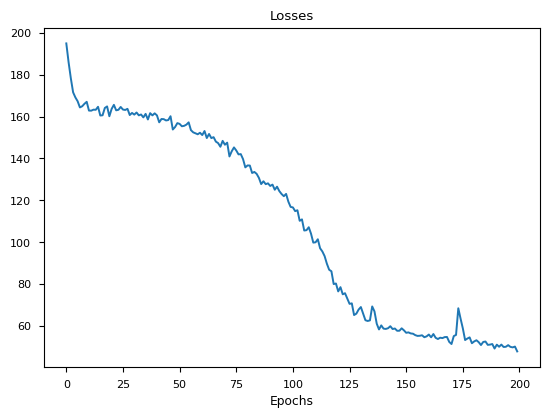

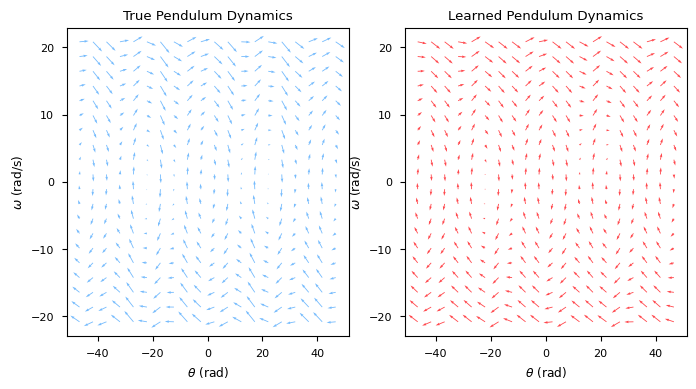

In [37]:
tf.random.set_seed(0)
dxdt = RotationalEncoding2dOrder2('tanh', best_init)
duration_s_2rot_order2, loss_2rot_order2 = experiment(dxdt, best_loss, None, terminal_only_loss, None, None,
                                                      epochs=epochs, lr=1e-3, traj_count=traj_count,
                                                      eval_traj_count=eval_traj_count, solver=solver,
                                                      solver_args=solver_args, batch_size=best_batch_size,
                                                      adjoint=adjoint, plot_rate=0)

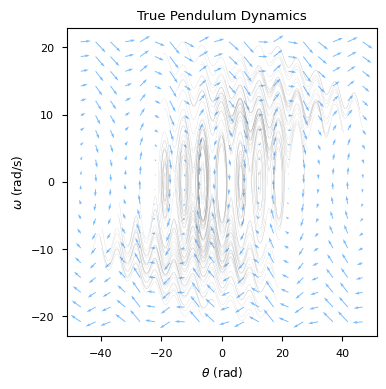

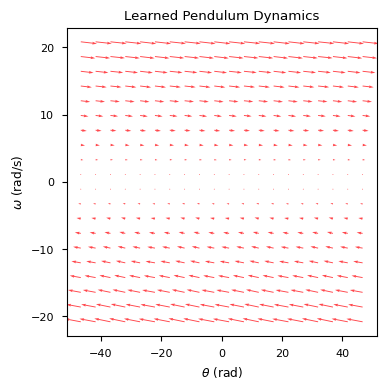

0: 209.43069640588828
1: 200.2036835905116
2: 192.127793236218
3: 185.47259949773482
4: 185.08065649500278
5: 183.93538935237524
6: 181.25129140677333
7: 181.61818602883437
8: 183.52715583699086
9: 184.19073327536645
10: 179.67236360709117
11: 179.86416919023802
12: 179.94621000891033
13: 180.352376271276
14: 180.84158281120125
15: 176.02838408968748
16: 174.5546414859386
17: 180.32860564056324
18: 180.22866899453462
19: 174.4900368314542
20: 177.84974874887283
21: 179.84255271645586
22: 176.86672508783636
23: 177.4657288259257
24: 177.50169601740143
25: 176.92313652462482
26: 177.10949689998057
27: 176.77873958784372
28: 173.83063626547937
29: 174.08880324721696
30: 173.54125255811257
31: 173.70870259072814
32: 172.67092595155086
33: 171.64183987677112
34: 171.14636651421816
35: 173.11053422031597
36: 168.81117941294056
37: 173.4307523450751
38: 171.32509077640756
39: 173.15703411263834
40: 170.93127248757455
41: 166.42757827188146
42: 168.770739423864
43: 168.31593148535555
44: 168.2

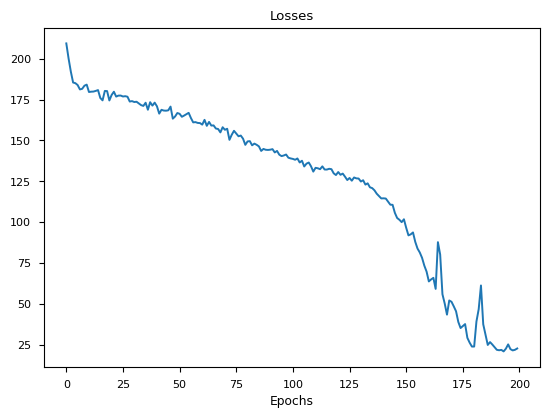

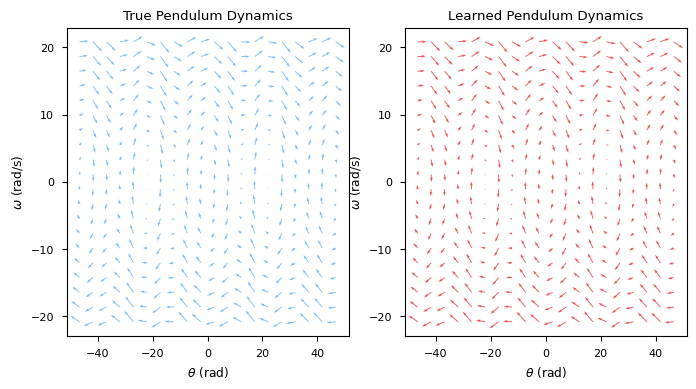

In [55]:
tf.random.set_seed(0)
dxdt_relu = RotationalEncoding2dOrder2('relu', best_init)
duration_s_2rot_order2_relu, loss_2rot_order2_relu = experiment(dxdt_relu, best_loss, None, terminal_only_loss, None, None,
                                                                epochs=epochs, lr=1e-3, traj_count=traj_count,
                                                                eval_traj_count=eval_traj_count, solver=solver,
                                                                solver_args=solver_args, batch_size=best_batch_size,
                                                                adjoint=adjoint, plot_rate=0)

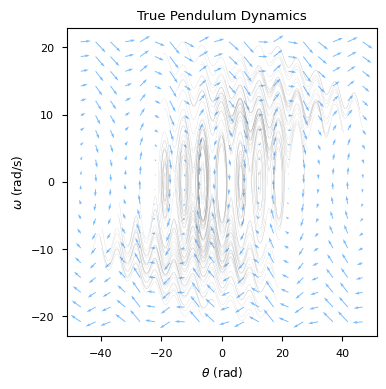

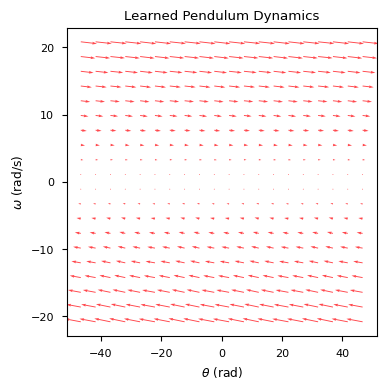

0: 209.42927204276026
1: 200.18565773158068
2: 192.1322998241104
3: 185.59089014139292
4: 185.26978770557238
5: 184.1676823715304
6: 181.62649870660192
7: 182.12584961497737
8: 184.2958779514972
9: 184.96879914929426
10: 180.4485175574815
11: 180.70480232833074
12: 180.75746548437428
13: 181.33672380805493
14: 181.82201338639658
15: 176.97297308336178
16: 175.41210531882734
17: 181.63540647619521
18: 181.6323036850663
19: 175.92989263329608
20: 179.3917018151638
21: 181.40497036915468
22: 178.20416186364537
23: 179.2960865606097
24: 179.29528022835422
25: 178.76807847089972
26: 179.16875345049274
27: 178.9194369924726
28: 176.00353798982812
29: 176.1215973608349
30: 176.00028980056376
31: 175.9920173169874
32: 175.27640614424536
33: 174.13081232756994
34: 173.96235401456784
35: 176.12302240303816
36: 171.7708868255401
37: 176.7258603123216
38: 174.56223485024265
39: 176.69822092395745
40: 174.44574640453556
41: 169.996650211264
42: 172.71611730736055
43: 172.41852334899798
44: 172.6473

In [ ]:
tf.random.set_seed(0)
dxdt_relu_adj = RotationalEncoding2dOrder2('relu', best_init)
duration_s_2rot_order2_relu_adj, loss_2rot_order2_relu_adj = experiment(dxdt_relu_adj, best_loss, None, terminal_only_loss, None, None,
                                                                        epochs=epochs, lr=1e-3, traj_count=traj_count,
                                                                        eval_traj_count=eval_traj_count, solver=solver,
                                                                        solver_args=solver_args, batch_size=best_batch_size,
                                                                        adjoint=True, plot_rate=0)

In [38]:
print(f"2nd order 2D rotation encoding - duration (s): {duration_s_2rot_order2:.2f}, loss (mse): {loss_2rot_order2:.2f}")

2nd order 2D rotation encoding - duration (s): 4338.55, loss (mse): 1.42


In [56]:
print("2nd order 2D rotation encoding:")
table = "| Activation | duration (s) | evaluation loss (mse) |\n| --- | --- | --- |\n"
table += f"| tanh | {duration_s_2rot_order2:.2f} | {loss_2rot_order2:.2f} |\n"
table += f"| tanh | {duration_s_2rot_order2_relu:.2f} | {loss_2rot_order2_relu:.2f} |"
display(Markdown(table))

2nd order 2D rotation encoding:


| Activation | duration (s) | evaluation loss (mse) |
| --- | --- | --- |
| tanh | 4338.55 | 1.42 |
| tanh | 6241.02 | 0.70 |

# Summary

In [57]:
table = """
| Model | Activation | Initialization | Loss Function | Batch Size | Adjoint | duration (s) | evaluation loss (mse) |
| ----- | ---------- | -------------- | ------------- | ---------- | ------- | ------------ | --------------------- |
"""
# batch size
table += "\n".join([f"| NODE| tanh | xaviar | terminal only | {batch_size} | False | {duration_s:.2f} | {loss:.2f} |"
                    for batch_size, (duration_s, loss) in batch_results.items()])

# activation
table += "\n".join([f"| NODE| {activation} | xaviar | terminal only | {best_batch_size} | False | {duration_s:.2f} | {loss:.2f} |"
                    for activation, (duration_s, loss) in activation_results.items()])

# initializer
table += "\n"
table += "\n".join([f"| NODE | tanh | {init_name} | terminal only | {best_batch_size} | False | {duration_s:.2f} | {loss:.2f} |"
                    for init_name, (duration_s, loss) in init_results.items()])

# terminal loss function
table += "\n"
table += "\n".join([f"| NODE | tanh | {best_init_name} | {loss_name} | {best_batch_size} | False | {duration_s:.2f} | {loss:.2f} |"
                    for loss_name, (duration_s, loss) in terminal_loss_results.items()])

# best with adjoint set to True
table += f"\n| NODE | tanh | {best_init_name} | {best_loss_name} | {best_batch_size} | True |" +\
         f"{duration_s_adj:.2f} | {loss_adj:.2f} |"

# specialized models
table += f"\n| 1D rotation encoding | tanh | {best_init_name} | {best_loss_name} | {best_batch_size} | False |" +\
         f"{duration_s_1rot:.2f} | {loss_1rot:.2f} |"
table += f"\n| 2D rotation encoding | tanh | {best_init_name} | {best_loss_name} | {best_batch_size} | False |" +\
         f"{duration_s_2rot:.2f} | {loss_2rot:.2f} |"
table += f"\n| 2nd order 1D rotation encoding | tanh | {best_init_name} | {best_loss_name} | {best_batch_size} | False |" +\
         f"{duration_s_1rot_order2:.2f} | {loss_1rot_order2:.2f} |"
table += f"\n| 2nd order 2D rotation encoding | tanh | {best_init_name} | {best_loss_name} | {best_batch_size} | False |" +\
         f"{duration_s_2rot_order2:.2f} | {loss_2rot_order2:.2f} |"
table += f"\n| 2nd order 2D rotation encoding | relu | {best_init_name} | {best_loss_name} | {best_batch_size} | False |" +\
         f"{duration_s_2rot_order2_relu:.2f} | {loss_2rot_order2_relu:.2f} |"

display(Markdown(table))


| Model | Activation | Initialization | Loss Function | Batch Size | Adjoint | duration (s) | evaluation loss (mse) |
| ----- | ---------- | -------------- | ------------- | ---------- | ------- | ------------ | --------------------- |
| NODE| tanh | xaviar | terminal only | 32 | False | 4876.69 | 4.95 |
| NODE| tanh | xaviar | terminal only | 64 | False | 2941.43 | 5.41 |
| NODE| tanh | xaviar | terminal only | 128 | False | 1377.25 | 6.01 |
| NODE| tanh | xaviar | terminal only | 256 | False | 740.61 | 8.11 |
| NODE| tanh | xaviar | terminal only | 512 | False | 727.64 | 8.11 |
| NODE| tanh | xaviar | terminal only | 1001 | False | 736.81 | 8.11 || NODE| tanh | xaviar | terminal only | 32 | False | 4975.87 | 4.54 |
| NODE| relu | xaviar | terminal only | 32 | False | 4543.19 | 4.19 |
| NODE | tanh | xavier | terminal only | 32 | False | 4498.91 | 4.95 |
| NODE | tanh | xavier_norm | terminal only | 32 | False | 4346.73 | 4.47 |
| NODE | tanh | init_random | terminal only | 32 | False | 4371.34 | 5.14 |
| NODE | tanh | init_random_norm | terminal only | 32 | False | 4316.95 | 5.12 |
| NODE | tanh | init_constant_0_5 | terminal only | 32 | False | 4359.86 | 6.77 |
| NODE | tanh | init_constant_1 | terminal only | 32 | False | 4395.08 | 12.67 |
| NODE | tanh | xavier_norm | terminal_only | 32 | False | 4310.60 | 4.47 |
| NODE | tanh | xavier_norm | all_states | 32 | False | 4260.57 | 4.46 |
| NODE | tanh | xavier_norm | all_states | 32 | True |4679.17 | 4.19 |
| 1D rotation encoding | tanh | xavier_norm | all_states | 32 | False |4429.67 | 4.11 |
| 2D rotation encoding | tanh | xavier_norm | all_states | 32 | False |4388.23 | 4.20 |
| 2nd order 1D rotation encoding | tanh | xavier_norm | all_states | 32 | False |4451.86 | 3.68 |
| 2nd order 2D rotation encoding | tanh | xavier_norm | all_states | 32 | False |4338.55 | 1.42 |
| 2nd order 2D rotation encoding | relu | xavier_norm | all_states | 32 | False |6241.02 | 0.70 |

## Other experiments to run:

* [x] 2nd order 1D rotation encoding
* [x] Try with adjoint set to True
* [ ] breaking up trajectory lengths into segments
* [ ] continous loss with dx/dt magnitude
* [ ] continuous loss with dx/dt divergence (jacobian product)
* [ ] continuous loss with both dx/dt magnitude and divergence
* [ ] What about dropout?

# More Experiments

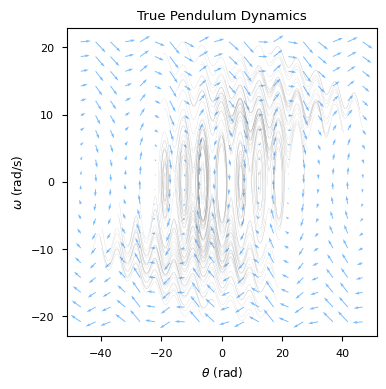

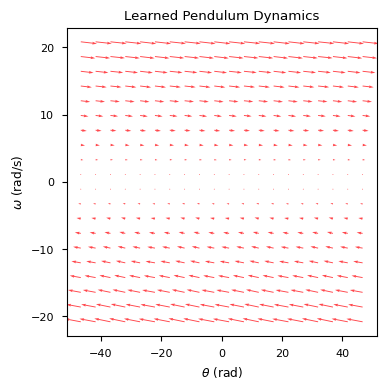

0: 209.42914694589135
1: 200.1837742588134
2: 192.12804115177732
3: 185.5847777285849
4: 185.26253733847742
5: 184.15994856599164
6: 181.61684594594817
7: 182.11658859328162
8: 184.28423105234805
9: 184.95673063079377
10: 180.43829094691935
11: 180.6950191405456
12: 180.75169531826234
13: 181.32631812937453
14: 181.81168721783493
15: 176.9665821346178
16: 175.418735158019
17: 181.6223019090435
18: 181.61789574313073
19: 175.92043881763965
20: 179.38160184039057
21: 181.39759410446337
22: 178.20432619842094
23: 179.285110926068
24: 179.2849529942992
25: 178.75967022041715
26: 179.159366170119
27: 178.9103232756829
28: 175.99235924798046
29: 176.1153234241127
30: 175.98481320706196
31: 175.98374878117556
32: 175.26457589044205
33: 174.1241732888163
34: 173.9519380097835
35: 176.10612051498342
36: 171.75978036200294
37: 176.71497828988237
38: 174.55220506418468
39: 176.68632646251802
40: 174.43047931352888
41: 169.98624816783922
42: 172.70538277503917
43: 172.403481347424
44: 172.63530085

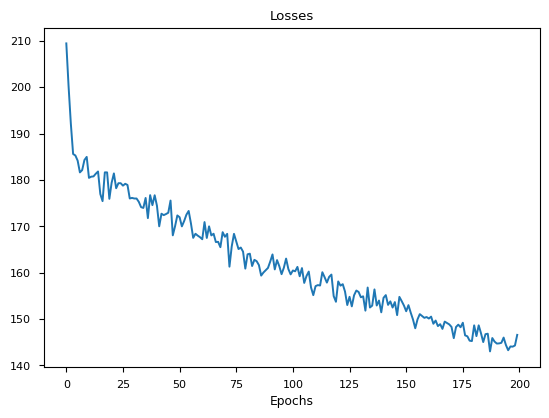

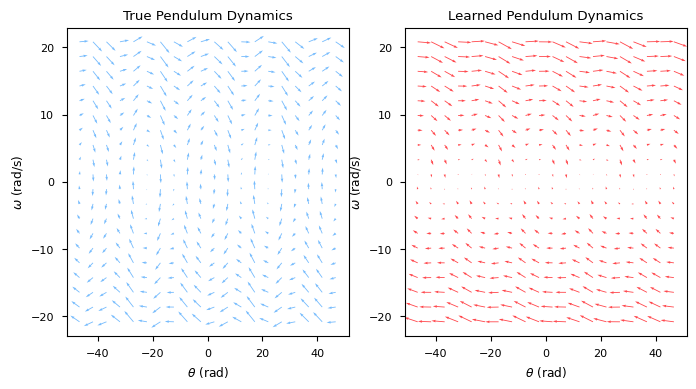

In [36]:
tf.random.set_seed(0)
dxdt_relu = RotationalEncoding2dOrder2('relu', xavier_norm)
optimal_transport_loss = create_optimal_transport_loss(dxdt_relu, 1e-4)
duration_s_2rot_order2_relu, loss_2rot_order2_relu = experiment(dxdt_relu, all_states_loss, optimal_transport_loss,
                                                                terminal_only_loss, None, None,
                                                                epochs=epochs, lr=1e-3, traj_count=traj_count,
                                                                eval_traj_count=eval_traj_count, solver=solver,
                                                                solver_args=solver_args, batch_size=32,
                                                                adjoint=True, plot_rate=0)

In [32]:
print(f"2nd order 2D rotation encoding with optimal transport - duration (s):" +\
      f"{duration_s_2rot_order2_relu:.2f}, loss (mse): {loss_2rot_order2_relu:.2f}")

2nd order 2D rotation encoding with optimal transport - duration (s):4049.87, loss (mse): 0.70
